In [1]:
import networkx as nx
from amplpy import AMPL
import matplotlib.pyplot as plt
import numpy as np
import time
import copy
import sys
import os
import contextlib
from sklearn.decomposition import PCA
import random

import matplotlib.lines as mlines
import matplotlib.patches as mpatches
from tabulate import tabulate
import optuna
import warnings
warnings.filterwarnings("ignore")
from pyswarm import pso
import multiprocessing

from network_layout import node_position
from matplotlib.patches import FancyArrowPatch, Rectangle
from matplotlib.lines import Line2D
from matplotlib.path import Path

class WaterNetworkOptimizer:
    def __init__(self, model_file, data_file, data_number, data_list):
        self.ampl = AMPL()
        self.model_file = model_file
        self.data_list = data_list
        self.data_file = data_file
        self.data_number = data_number
        self.total_cost = None
        self.network_graph = None
        self.solve_result = None
        self.solver_time = 0
        self.best_acyclic_flow = None
        self.number_of_nlp = 0

    def load_model(self):
        """Load the model and data."""
        self.ampl.reset()
        self.ampl.read(self.model_file)
        self.ampl.read_data(self.data_file)
        
        self.nodes = self.ampl.getSet('nodes')
        self.source = self.ampl.getSet('Source')
        self.arcs = self.ampl.getSet('arcs')
        self.pipes = self.ampl.getSet('pipes')
        
        self.L = self.ampl.getParameter('L').to_dict()
        self.D = self.ampl.getParameter('D').to_dict()
        self.C = self.ampl.getParameter('C').to_dict()
        self.P = self.ampl.getParameter('P').to_dict()
        self.R = self.ampl.getParameter('R').to_dict()
        self.E = self.ampl.getParameter('E').to_dict()
        self.d = self.ampl.getParameter('d').to_dict()
        #self.eps = self.ampl.getParameter('eps').to_list()[0]
        
        
        self.delta = 0.1
        self.p = 1.852
        self.omega = 10.67

    def create_digraph(self):
        nodes_list = [i for i in self.ampl.getSet('nodes')]
        edges_list = self.ampl.getSet('arcs').to_list()
        self.network_graph = nx.DiGraph()
        self.network_graph.add_nodes_from(nodes_list)
        self.network_graph.add_edges_from(edges_list)
        print(nodes_list)
        print(edges_list)

    def display_results(self):
        """Display relevant results from the optimization."""
        self.ampl.eval("display {(i,j) in arcs, k in pipes:l[i,j,k]>1} l[i,j,k];")
        self.ampl.eval("display {(i,j) in arcs}: q[i,j];")
        self.ampl.eval("display h;")
        self.ampl.eval("display solve_result;")
        self.total_cost = self.ampl.get_objective("total_cost").value()
        print("Objective:", self.total_cost)
        # self.ampl.eval("display {(i,j) in arcs} h[i] - h[j];")
        # self.ampl.eval("display {i in nodes} h[i] - (E[i] + P[i]);")

    # def plot_graph(self):
    #     print("Edges of the graph:",self.network_graph.edges())
    #     plt.figure(figsize=(10, 8))
    #     nx.draw_spectral(self.network_graph, with_labels=True)
    #     plt.show()


    def plot_graph1(self, super_source_out_arc=None, best_arc=None,current_cost = None, iteration= 1):
        # print("Edges of the graph:", self.network_graph.edges())
        indegree_2_or_more = [node for node, indeg in self.network_graph.in_degree() if indeg >= 2]
        
        plt.figure(figsize=(10, 8))
        pos = nx.spectral_layout(self.network_graph)
        nx.draw_networkx_nodes(self.network_graph, pos, node_color='lightblue', node_size=200)
        
        if indegree_2_or_more:
            nx.draw_networkx_nodes(self.network_graph, pos, nodelist=indegree_2_or_more, node_color='orange', node_size=200)
            
        nx.draw_networkx_labels(self.network_graph, pos)
        nx.draw_networkx_edges(self.network_graph, pos, edge_color='black')
        
        if super_source_out_arc:
            nx.draw_networkx_edges(self.network_graph, pos, edgelist=super_source_out_arc, edge_color='red', width=1)
            
        if best_arc:
            nx.draw_networkx_edges(self.network_graph, pos, edgelist=[best_arc], edge_color='magenta', width=1)
            
        plt.title(f"total_cost:{self.total_cost}")
        plt.savefig(f"/home/nitishdumoliya/waterNetwork/wdnd/figure/d{self.data_number}_iteration_{iteration}.png")
        plt.box(False)
        plt.show()

    def plot_graph2(self, super_source_out_arc=None, current_cost = None, iteration = 1, edge_weights= None, h = None, D = None, arc=(0,0), l ={}, C = {}):
        # self.network_graph = nx.DiGraph()
        # self.network_graph.add_edges_from(edges)
        # Node positions as per your specifications
        
        pos = node_position[self.data_number]
        # pos = nx.spectral_layout(self.network_graph)

        cost = {}

        for (i,j) in self.ampl.getSet('arcs'):
            cost[i,j] = sum(l[i,j,k] * C[k] for k in self.ampl.getSet('pipes'))
        
        plt.figure(figsize=(10, 6))
        cmap = plt.cm.plasma
        
        nx.draw_networkx_nodes(self.network_graph, pos, node_color='white',edgecolors="black", node_size=100,linewidths=0.5, label='Regular Nodes')
        
        indegree_2_or_more = [node for node, indeg in self.network_graph.in_degree() if indeg >= 2]
        #if indegree_2_or_more:
        #    nx.draw_networkx_nodes(self.network_graph, pos, nodelist=indegree_2_or_more, node_color='orange',edgecolors="orange", node_size=300, label='Nodes with In-Degree ≥ 2')
        
        # nx.draw_networkx_nodes(self.network_graph, pos, nodelist=list(self.source), node_color='cornflowerblue',edgecolors="black", node_size=300,linewidths=0.5, label='Source node')
        # if not self.visited_nodes:
        #     nx.draw_networkx_nodes(self.network_graph, pos, nodelist=indegree_2_or_more, node_color='orange',edgecolors="black", node_size=300,linewidths=0.5, label='Nodes with In-Degree ≥ 2')
            
        #if self.sorted_nodes:
        #    nx.draw_networkx_nodes(self.network_graph, pos, nodelist=self.sorted_nodes, node_color='orange',edgecolors="black", node_size=300,linewidths=0.5, label='Visited nodes')
        source = list(self.ampl.getSet('Source'))

        # if source:
            # nx.draw_networkx_nodes(self.network_graph, pos, nodelist=source, node_color='cornflowerblue',edgecolors="black", node_size=100,linewidths=0.5, label='Visited nodes')
            
        #if self.visited_nodes:
        #    visited_nodes = [item for item in  self.visited_nodes if item in self.indegree_2_or_more]
        #    nx.draw_networkx_nodes(self.network_graph, pos, nodelist=visited_nodes, node_color='violet',edgecolors="black", node_size=300,linewidths=0.5, label='Sorted nodes')

        
        nx.draw_networkx_labels(self.network_graph, pos, font_size=5)
        
        nx.draw_networkx_edges(self.network_graph, pos, arrowstyle="->", arrowsize=12, edge_color='black', label='Regular Arcs', arrows=False) # arrows=False

        #if super_source_out_arc:
        #    nx.draw_networkx_edges(self.network_graph, pos, edgelist=super_source_out_arc,arrowstyle="->", arrowsize=12, edge_color='red', width=1, label='Fix arc direction')
        
        # if best_arc:
        #     nx.draw_networkx_edges(self.network_graph, pos, edgelist=[best_arc],arrowstyle="->", arrowsize=12, edge_color='magenta', width=1, label = 'Best arc')
        # Annotate node demands
        if h:
            for node, (x, y) in pos.items():
                demand = h.get(node, 0)  # Get the head for the node, default to 0 if not in dictionary
                # plt.text(x, y + 120, f"{demand:.2f}", fontsize=8, color='blue', ha='center')  # Annotate demand below the node
                # plt.text(x, y + 200, f"{demand:.2f}", fontsize=8, color='blue', ha='center')  # Annotate demand below the node
                # plt.text(x, y -100 , f"{demand:.2f}", fontsize=8, color='magenta', ha='center')  # Annotate demand below the node
                # plt.text(mid_x, mid_y + 50 , f"{weight:.2f}", fontsize=8, color='green', ha='center')  # Annotate weight on edge
                # plt.text(mid_x, mid_y + 100, f"{value:.2f}", fontsize=8, color='green', ha='center')  # Annotate weight on edge
        if D:
            for node, (x, y) in pos.items():
                demand = D.get(node, 0)  # Get the demand for the node, default to 0 if not in dictionary
                #plt.text(x-250, y - 400, f"{demand:.2f}", fontsize=10, color='black', ha='center')  # Annotate demand below the node
                # plt.text(x-80, y - 130 , f"{demand:.2f}", fontsize=10, color='magenta', ha='center')  # Annotate demand below the node
            
        if edge_weights:
            for (u, v), weight in edge_weights.items():
                # if self.network_graph.has_edge(u, v):
                mid_x = (pos[u][0] + pos[v][0]) / 2  # Midpoint x-coordinate
                mid_y = (pos[u][1] + pos[v][1]) / 2  # Midpoint y-coordinate
                # plt.text(mid_x+270, mid_y+180 , f"{weight:.2f}", fontsize=10, color='black', ha='center')  # Annotate weight on edge
                # plt.text(mid_x+90, mid_y + 50 , f"{weight:.2f}", fontsize=10, color='black', ha='center')  # Annotate weight on edge
        if cost:
            for (u, v), value in cost.items():
                # if self.network_graph.has_edge(u, v):
                mid_x = (pos[u][0] + pos[v][0]) / 2  # Midpoint x-coordinate
                mid_y = (pos[u][1] + pos[v][1]) / 2  # Midpoint y-coordinate
                # plt.text(mid_x, mid_y-300 , f"{round(value)}", fontsize=8, color='purple', ha='center')  # Annotate weight on edge
                # plt.text(mid_x, mid_y + 100, f"{value:.2f}", fontsize=8, color='green', ha='center')  # Annotate weight on edge
        pipe_dia_arc = {}
        for (i,j) in self.arcs:
            list_=[]
            for k in self.pipes:
                if l[i,j,k]>= 1e-5:
                    list_.append(k)
            pipe_dia_arc[i,j] = list_
        
        if pipe_dia_arc:
            for (u, v), weight in pipe_dia_arc.items():
                # if self.network_graph.has_edge(u, v):
                mid_x = (pos[u][0] + pos[v][0]) / 2  # Midpoint x-coordinate
                mid_y = (pos[u][1] + pos[v][1]) / 2  # Midpoint y-coordinate
                # plt.text(mid_x - 200, mid_y - 300 , f"{weight}", fontsize=10, color='purple', ha='center')  # Annotate weight on edge
                # plt.text(mid_x-80, mid_y+120 , f"{weight}", fontsize=10, color='green', ha='center')  # Annotate weight on edge
        
        regular_node_patch = mpatches.Patch(color='lightblue', label='Regular Nodes')
        indegree_node_patch = mpatches.Patch(color='orange', label='Nodes with In-Degree ≥ 2')
        regular_edge_line = mlines.Line2D([], [], color='black', label='Regular Arcs')
        super_source_edge_line = mlines.Line2D([], [], color='red', label='Fix arc direction')
        # best_edge_line = mlines.Line2D([], [], color='magenta', label='Best Arc')
        # plt.legend(handles=[regular_node_patch, indegree_node_patch, regular_edge_line, super_source_edge_line], loc='lower right')
        
        # cost = round(self.total_cost)
        # res = f"{cost:,}"
        # plt.title(f"Total cost: {self.format_indian_number(cost)}")
        # (u,v) = arc
        
        
        # === 1. Draw smaller open tank at node 1 ===
        tank_width, tank_height = 500, 500  # reduced size
        tank_center = pos[1]
        tank_x = tank_center[0] - tank_width / 2
        tank_y = tank_center[1] - tank_height / 2

        # Draw water (lower half filled)
        water_height = tank_height / 2
        water_fill = Rectangle((tank_x, tank_y), tank_width, water_height,
                               linewidth=0, edgecolor=None, facecolor='cornflowerblue', zorder=4)
        plt.gca().add_patch(water_fill)

        # Draw open tank (left, right, bottom only)
        left_line = Line2D([tank_x, tank_x], [tank_y, tank_y + tank_height], color='black', linewidth=1.5, zorder=5)
        right_line = Line2D([tank_x + tank_width, tank_x + tank_width], [tank_y, tank_y + tank_height], color='black', linewidth=1.5, zorder=5)
        bottom_line = Line2D([tank_x, tank_x + tank_width], [tank_y, tank_y], color='black', linewidth=1.5, zorder=5)
        plt.gca().add_line(left_line)
        plt.gca().add_line(right_line)
        plt.gca().add_line(bottom_line)

        # Draw label "1" to the left of the tank
        plt.text(tank_x - 40, tank_center[1], "1", fontsize=10, ha='right', va='center', color='black', zorder=6)


        # plt.savefig(f"/home/nitishdumoliya/waterNetwork/model/wdnd/figure/d{self.data_number}_iteration_{iteration}.png")
        plt.savefig(f"/home/nitishdumoliya/waterNetwork/wdnd/figure/d{self.data_number}.pdf", format="pdf", dpi=1000, bbox_inches="tight")

        plt.box(False)
        plt.show()
    
    def plot_graph(self, super_source_out_arc=None, current_cost=None, iteration=1,
                   edge_weights=None, h=None, D=None, arc=(0, 0), l={}, C={}):
        pos = node_position[self.data_number]
        cost = {}

        for (i, j) in self.ampl.getSet('arcs'):
            cost[i, j] = sum(l[i, j, k] * C[k] for k in self.ampl.getSet('pipes'))

        plt.figure(figsize=(10, 6))
        cmap = plt.cm.plasma

        source = list(self.ampl.getSet('Source'))
        draw_nodes = [n for n in self.network_graph.nodes if n not in source]

        # === Draw regular nodes (excluding source node) ===
        nx.draw_networkx_nodes(self.network_graph, pos, nodelist=draw_nodes, node_color='white',
                               edgecolors="black", node_size=100, linewidths=0.5, label='Regular Nodes')

        # === Draw labels for regular nodes only ===
        nx.draw_networkx_labels(self.network_graph, pos, font_size=5,
                                labels={n: n for n in draw_nodes})

        # === Draw regular edges (exclude arcs from source nodes) ===
        # regular_edges = [(i, j) for (i, j) in self.network_graph.edges if i not in source]
        nx.draw_networkx_edges(self.network_graph, pos, edgelist=self.network_graph.edges,
                               arrowstyle="->", arrowsize=12, edge_color='black', arrows=False)

        # === Draw tanks and custom outgoing arcs ===
        for s_node in source:
            if s_node not in pos:
                continue

            tank_width, tank_height = 500, 500
            tank_center = pos[s_node]
            tank_x = tank_center[0] 
            tank_y = tank_center[1] - tank_height / 2

            # Water (lower half)
            water_height = tank_height / 2
            water_fill = Rectangle((tank_x, tank_y), tank_width, water_height,
                                   linewidth=0, edgecolor=None, facecolor='cornflowerblue', zorder=4)
            plt.gca().add_patch(water_fill)

            # Tank outline
            left_line = Line2D([tank_x, tank_x], [tank_y, tank_y + tank_height],
                               color='black', linewidth=1.5, zorder=5)
            right_line = Line2D([tank_x + tank_width, tank_x + tank_width], [tank_y, tank_y + tank_height],
                                color='black', linewidth=1.5, zorder=5)
            bottom_line = Line2D([tank_x, tank_x + tank_width], [tank_y, tank_y],
                                 color='black', linewidth=1.5, zorder=5)
            plt.gca().add_line(left_line)
            plt.gca().add_line(right_line)
            plt.gca().add_line(bottom_line)

            # Optional: label near tank, not between tank and arc
            plt.text(tank_x + tank_height/2, tank_y + tank_height, f"{s_node}", fontsize=10,
                     ha='center', va='center', color='black', zorder=6)

            # === Draw custom outgoing arcs from tank bottom-left to connected nodes ===
#             for to_node in self.network_graph.successors(s_node):
#                 if to_node not in pos:
#                     continue

#                 end_x, end_y = pos[to_node]
#                 start_x = tank_x
#                 start_y = tank_y

#                 plt.arrow(start_x, start_y, end_x - start_x, end_y - start_y,
#                           length_includes_head=True, head_width=100, head_length=200,
#                           fc='black', ec='black', alpha=0.8, zorder=6)

        # === Save and display ===
        plt.box(False)
        plt.savefig(f"/home/nitishdumoliya/waterNetwork/wdnd/figure/d{self.data_number + 1}.pdf",
                    format="pdf", dpi=1000, bbox_inches="tight")
        plt.show()

    
    def cycle_basis(self):
        root = self.ampl.getSet('Source').to_list()[0]
        nodes_list = [i for i in self.ampl.getSet('nodes')]
        edges_list = self.ampl.getSet('arcs').to_list() 
        uwg = nx.Graph()
        uwg.add_nodes_from(nodes_list)
        uwg.add_edges_from(edges_list)
        # print("Edges in the undirected graph:", edges_list)
        print("cycle basis for given water network: ",nx.cycle_basis(uwg, root))
        
    def generate_random_acyclic_from_solution(self, q):
        # print("Generate the acyclic network using ipopt solution")
        
        self.network_graph = nx.DiGraph()
        self.network_graph.add_nodes_from(self.nodes)
        
        # q = self.ampl.getVariable('q').getValues().toDict()
        for (i,j) in self.arcs:
            if q[i,j] >= 0:
                self.network_graph.add_edge(i,j)
            else:
                self.network_graph.add_edge(j,i)
        
        return self.network_graph

    
    def generate_random_acyclic_graph(self):
        uwg = nx.Graph()
        nodes_list = [i for i in self.ampl.getSet('nodes')]
        edges_list = self.ampl.getSet('arcs').to_list()
        uwg.add_nodes_from(nodes_list)
        uwg.add_edges_from(edges_list)
        print("Edges in the undirected graph:", edges_list)
        
        # Generate a random spanning tree using Wilson's algorithm
        random_tree = nx.random_spanning_tree(uwg)
        
        # Retrieve the root from the AMPL source set
        root_l = self.ampl.getSet('Source').to_list()
        root = root_l[0]
        print("Root node:", root)

        # Ensure the root is present in the random tree
        if root not in random_tree.nodes:
            raise ValueError("The specified root must be a node in the graph.")

        # Create a directed graph from the random tree starting from the specified root
        self.network_graph = nx.DiGraph()
        visited = set()

        def dfs(node):
            visited.add(node)
            for neighbor in random_tree.neighbors(node):
                if neighbor not in visited:
                    self.network_graph.add_edge(node, neighbor) 
                    dfs(neighbor)

        # Start DFS from the specified root
        dfs(root)

        # Draw the initial directed tree
        plt.figure(figsize=(15, 10))
        plt.subplot(121)
        nx.draw_spectral(self.network_graph, with_labels=True, node_color='lightgreen', font_weight='bold', arrows=True)
        plt.title("Directed Spanning Tree")

        # Add remaining edges from the original graph and check for cycles
        for u, v in uwg.edges():
            if not self.network_graph.has_edge(u, v):  
                self.network_graph.add_edge(u, v)  
                if not nx.is_directed_acyclic_graph(self.network_graph):  
                    self.network_graph.remove_edge(u, v)  
                    self.network_graph.add_edge(v, u)  

        # Draw the final directed graph after adding remaining edges
        plt.subplot(122)
        nx.draw_spectral(self.network_graph, with_labels=True, node_color='lightgreen', font_weight='bold', arrows=True)
        plt.title("Acyclic Directed Graph")
        plt.show()

    def update_model(self):
        # print("Fix the arcs direction using the acyclic network\n")
        edges_list = [(arc[0],arc[1]) for arc in self.ampl.getSet('arcs')]
        for edge in self.network_graph.edges:
            i, j = edge
            if edge in edges_list:
                self.ampl.eval(f"s.t. flow_direction{i}_{j}: q[{i},{j}] >=0;")
                # self.ampl.eval(f"s.t. head_bound_left{i}_{j}: E[{j}]+P[{j}] <= h[{j}];")
                # self.ampl.eval(f"s.t. head_bound_right{i}_{j}: E[{j}] + P[{j}] <= h[{i}];")
            else:
                self.ampl.eval(f"s.t. flow_direction{i}_{j}: q[{j},{i}] <=0;")
                # self.ampl.eval(f"s.t. head_bound_left{i}_{j}: E[{i}]+P[{i}] <= h[{i}];")
                # self.ampl.eval(f"s.t. head_bound_right{i}_{j}: E[{i}] + P[{i}] <= h[{j}];")  


    def is_valid_edge(self, source, target):
        """Check if adding the directed edge (source -> target) maintains acyclicity."""
        self.network_graph.add_edge(source, target)  # Temporarily add the edge
        is_dag = nx.is_directed_acyclic_graph(self.network_graph)  # Check for acyclicity
        self.network_graph.remove_edge(source, target)  # Remove the edge after checking
        return is_dag  # Return True if it maintains acyclicity     
    
    def check_incoming_arcs(self):
        root = list(self.ampl.getSet('Source'))[0]
        # Iterate over all nodes in the graph
        for node in self.network_graph.nodes():
            # Skip the root node
            if node == root:
                continue
            # Check if the in-degree of the node is at least 1
            if self.network_graph.in_degree(node) < 1:
                # print(f"Node {node} does not have any incoming arcs.")
                return False
        # print("All nodes except the root have at least one incoming arc.")
        return True
            
    def format_indian_number(self,num):
        num_str = str(num)
        if len(num_str) <= 3:
            return num_str
        else:
            # Split the number into the last three digits and the rest
            last_three = num_str[-3:]
            remaining = num_str[:-3]
            # Add commas every two digits in the remaining part
            remaining = ','.join([remaining[max(i - 2, 0):i] for i in range(len(remaining), 0, -2)][::-1])
            return remaining + ',' + last_three

    def fix_leaf_arc_flow(self):
        graph = nx.Graph()
        arc_set = self.ampl.getSet('arcs').to_list()  
        graph.add_edges_from(arc_set)
        D = self.ampl.getParameter('D').getValues().to_dict()  
        source = self.ampl.getSet('Source').to_list()[0]
        fixed_arcs = set()
        # print("\nPresolve the model for fixing the flow value in the leaf arcs")
        # print("Source:",self.ampl.getSet('Source').to_list())

        while True:
            leaf_nodes = [node for node in graph.nodes if graph.degree[node] == 1]
            # print("leaf_nodes:", leaf_nodes)
            if not leaf_nodes:  
                break

            for leaf in leaf_nodes:
                neighbor = next(graph.neighbors(leaf))
                if (neighbor, leaf) in arc_set:
                    edge = (neighbor, leaf)
                    if edge not in fixed_arcs:  
                        if leaf == source:
                            flow_value = D[leaf]
                            D[neighbor] = (D[neighbor]+flow_value)
                            source = neighbor
                        else:
                            flow_value = D[leaf]
                            D[neighbor] = D[neighbor] + flow_value
                        #self.ampl.eval(f"s.t. fix_q_{edge[0]}_{edge[1]}: q[{edge[0]},{edge[1]}] = {flow_value};")
                        # print(f"Fixing flow for arc {edge}: {flow_value}")
                        fixed_arcs.add(edge)  

                    graph.remove_node(leaf)
                else:
                    edge = (leaf, neighbor)
                    if edge not in fixed_arcs:  
                        if leaf == source:
                            flow_value = -D[leaf]
                            D[neighbor] = D[neighbor]-flow_value
                            source = neighbor
                            #self.ampl.eval(f"s.t. fix_q_{edge[0]}_{edge[1]}: q[{edge[0]},{edge[1]}] = {flow_value};")
                        elif neighbor == source:
                            flow_value = -D[leaf]
                            D[neighbor] = D[neighbor] - D[leaf] 
                            #self.ampl.eval(f"s.t. fix_q_{edge[0]}_{edge[1]}: q[{edge[0]},{edge[1]}] = {flow_value};")
                        else:
                            flow_value = -D[leaf]
                            D[neighbor] += -flow_value
                            #self.ampl.eval(f"s.t. fix_q_{edge[0]}_{edge[1]}: q[{edge[0]},{edge[1]}] = {flow_value};")
                        # priqnt(f"Fixing flow for arc {edge}: {flow_value}")
                        fixed_arcs.add(edge)  
                    graph.remove_node(leaf)
        # print("All leaf arc flows have been fixed.")
        return fixed_arcs

    def is_cycle(self, graph, start_node, end_node, visited_copy, parent):
        visited_copy[start_node] = True
        # print(f"Is node {end_node} in cycle?")
        for neighbor in graph.neighbors(start_node):
            # print("visited",neighbor,visited_copy[neighbor])
            if not visited_copy[neighbor]:
                # print("neighbor of node", start_node, "is", neighbor)
                isCycle = self.is_cycle(graph, neighbor, end_node, visited_copy, start_node)
                if isCycle:
                    return True
            else:
                # print("parent:", parent)
                if parent != neighbor:
                    if end_node == neighbor:
                        # print(f"Node {end_node} is in cycle")
                        return True
        return False

    def presolve(self, graph, node, visited, parent, set_arc):
        visited_copy = visited.copy()
        # print(visited_copy)
        isCycle = self.is_cycle(graph, node, node, visited_copy, parent)
        # print(f"Is node {node} in cycle?",isCycle)
        visited[node] = True
        if isCycle:
            for neighbor in graph.neighbors(node):
                if parent!=neighbor:
                    set_arc.append((node,neighbor))
                    # print("Fix the arc", (node, neighbor))
            return set_arc
        else:
            for neighbor in graph.neighbors(node):
                if parent != neighbor:
                    set_arc.append((node,neighbor))
                    # print(set_arc)
                    # print("Fix the arc", (node, neighbor))
                    # print("neighbor:", neighbor)
                    self.presolve(graph, neighbor, visited, node, set_arc)
        return set_arc

    def fix_arc_set(self):
        graph = nx.Graph()
        arc_set = self.ampl.getSet('arcs').to_list()
        graph.add_edges_from(arc_set)
        visited = {node: False for node in graph.nodes()}
        source = self.ampl.getSet('Source').to_list()[0]
        set_arc = []
        # print("\nPresolve the model for fixing the arc direction")
        set_ = self.presolve(graph, source, visited, -1, set_arc)
        # print("fixed arc direction:",set_, "\n") 
        return set_

    def update_initial_points(self,l_solution, q_solution, h_solution):
        for (i, j, k), val in l_solution.items():
            self.ampl.eval(f'let l[{i},{j},{k}] := {val};')
        for (i, j), val in q_solution.items():
            self.ampl.eval(f'let q[{i},{j}] := {val};')
        for i, val in h_solution.items():
            self.ampl.eval(f'let h[{i}] := {val};')

    def update_initial_points1(self, l_solution, q_solution, h_solution,all_duals, inarc):
        for (i, j, k), val in l_solution.items():
            self.ampl.eval(f'let l[{i},{j},{k}] := {val};')
        
        edge_list_network = self.network_graph.edges
        
        for i, val in h_solution.items():
            self.ampl.eval(f'let h[{i}] := {val};')
        
        for (i, j), val in q_solution.items():
            edge = (i, j) 
            if edge in edge_list_network:
                if (i,j) not in inarc:
                    # print(f"self.ampl.eval(let q[{i},{j}] := {val};)")
                    self.ampl.eval(f"let q[{i},{j}] := {val} ;")
                else:
                    # print(f"self.ampl.eval(let q[{i},{j}] := {-val};)")
                    self.ampl.eval(f"let q[{i},{j}] := {val} ;")
            else:
                if (j,i) not in inarc:
                    # print(f"self.ampl.eval(let q[{i},{j}] := {val};)")
                    self.ampl.eval(f"let q[{i},{j}] := {val};")
                else:
                    # print(f"self.ampl.eval(let q[{j},{i}] := {-val};)")
                    self.ampl.eval(f"let q[{j},{i}] := {val} ;")
        
        # current_duals = {}
        # for con_name, val in self.ampl.get_constraints():
        #     dual_values = val.get_values()
        #     current_duals[con_name] = dual_values

        # Initialize dual values for all constraints
        # for con_name, dual_values in all_duals.items():
            # if con_name in current_duals:
                # Initialize dual values for each constraint
                # self.ampl.get_constraint(con_name).set_values(dual_values)
            # else:
            #     print(f"Skipping initialization for constraint: {con_name} (not in current model)")
    
    def update_initial_points_with_perturbation(self, l_solution, q_solution, h_solution,all_duals, inarc, delta=0.1):
        edge_list_network = self.network_graph.edges
        L = self.ampl.getParameter('L').getValues().to_dict()
        # Perturb l values
        for (i, j, k), val in l_solution.items():
            if (i,j) not in inarc:
                if val>= 1e-5:
                    perturbation = random.gauss(0, 1)
                    new_val = val + perturbation
                    # if val >= 1e-5:
                    self.ampl.eval(f'let l[{i},{j},{k}] := {new_val};')
                else:
                    self.ampl.eval(f'let l[{i},{j},{k}] := {0};')
            else:
                if val>= 1e-5:
                    perturbation = random.gauss(0, 1)
                    new_val = val + perturbation
                    self.ampl.eval(f'let l[{i},{j},{k}] := {new_val};')
                else:
                    self.ampl.eval(f'let l[{i},{j},{k}] := {0};')
                    
        # Perturb h values
        for i, val in h_solution.items():
            perturbation = random.gauss(0, 1)
            new_val = val + perturbation
            self.ampl.eval(f'let h[{i}] := {new_val};')

        # Modify q values based on heuristic
        for (i, j), val in q_solution.items():
            edge = (i, j)
            perturbation = random.gauss(0, 1)
            if edge in edge_list_network:
                if (i, j) not in inarc:
                    self.ampl.eval(f"let q[{i},{j}] := {val + perturbation};")
                else:
                    self.ampl.eval(f"let q[{i},{j}] := {(val + perturbation)};")
            else:
                if (j, i) not in inarc:
                    self.ampl.eval(f"let q[{i},{j}] := {val + perturbation};")
                else:
                    self.ampl.eval(f"let q[{j},{i}] := {(val + perturbation)};")
        
        current_duals = {}
        for con_name, val in self.ampl.get_constraints():
            dual_values = val.get_values()
            current_duals[con_name] = dual_values

        # Initialize dual values for all constraints
        for con_name, dual_values in all_duals.items():
            if con_name in current_duals:
                # Initialize dual values for each constraint
                self.ampl.get_constraint(con_name).set_values(dual_values)

    def multistart(self, inarc, current_cost, best_acyclic_flow, improved, super_source_out_arc, iteration):
        improved = False
        max_l = max(self.ampl.getParameter('L').to_dict().values())
        max_q = self.ampl.getParameter('D').getValues().toDict()
        # print(max_q[1])
        # for i, value in max_q.items():
        #     print(value)
        
        source = self.ampl.getSet('Source').to_list()
        E = self.ampl.getParameter('E').getValues().toDict()
        P = self.ampl.getParameter('P').getValues().toDict()
        
        # Define the number of starts for multistart heuristic
        num_starts = 10
        
        # Set a random seed for reproducibility
        random.seed(num_starts)
        
        # Loop for multistart heuristic
        for start in range(num_starts):
            
            for (i,j) in self.arcs:
                for k in self.pipes:
                    value = random.uniform(0, max_l)  
                    self.ampl.eval(f' let l[{i},{j},{k}] := {self.l[i,j,k]};')
                    
            for (i,j) in self.network_graph.edges:
                if (i,j) not in inarc:
                    if (i,j) in self.arcs:
                        value = random.uniform(0, -max_q[1])
                        self.ampl.eval(f'let q[{i},{j}] := {value};')
                    else:
                        value = random.uniform(max_q[1], 0)
                        self.ampl.eval(f'let q[{j},{i}] := {value};')
                else:
                    if (i,j) in self.arcs:
                        value = random.uniform(0, -max_q[1])
                        self.ampl.eval(f'let q[{i},{j}] := {value};')
                    else:
                        value = random.uniform(max_q[1], 0)
                        self.ampl.eval(f'let q[{j},{i}] := {value};')
            
            # for (i,j) in self.ampl.get_set("arcs").to_list():
            #     value = random.uniform(max_q[1], -max_q[1])  
            #     self.ampl.eval(f'let q[{i},{j}] := {value};')
            
            for i in self.nodes:
                value = random.uniform(E[i]+P[i], E[source[0]])  
                self.ampl.eval(f'let h[{i}] := {self.h[i]};')
                
            self.ampl.set_option("solver", "ipopt")
            self.ampl.set_option("ipopt_options", "outlev = 0 expect_infeasible_problem = yes bound_push = 0.001 bound_frac = 0.001 warm_start_init_point = yes")
            # ampl.option[""]
            self.ampl.solve()
            
            if self.ampl.solve_result == 'solved':
                cost = self.ampl.get_objective("total_cost").value()
                print(cost)
                
                # Update the best solution if the current cost is lower
                if cost < current_cost:
                    improved = True
                    current_cost = cost
                    self.generate_random_acyclic_from_solution()
                    best_acyclic_flow = self.network_graph.copy()
                    l = self.ampl.getVariable('l').getValues().to_dict()
                    q = self.ampl.getVariable('q').getValues().to_dict()
                    h = self.ampl.getVariable('h').getValues().to_dict()
                    D = self.ampl.getParameter('D').getValues().to_dict()
                    self.plot_graph(super_source_out_arc, current_cost, iteration, q, h, D)
                    # print(best_acyclic_flow, improved, current_cost, l, q, h)
                # else:
                #     pass
        if improved:
            return best_acyclic_flow, improved, current_cost, l, q, h
        else:
            return self.best_acyclic_flow, improved, current_cost, self.l, self.q, self.h
                    
        # return best_acyclic_flow, improved, current_cost, l, q, h

    def acyclic_arcs(self):
        network_graph = self.best_acyclic_flow
        indegree_2_or_more = [node for node, indeg in network_graph.in_degree() if indeg >= 2]
        acyclic_arc = set()
        for node in indegree_2_or_more:
            # print("Node:", node,"in_degree:", self.network_graph.in_degree(node))
            for edge in list(network_graph.in_edges(node)):
                (u, v) = edge
                if (u,v) not in self.super_source_out_arc :
                    network_graph.remove_edge(u,v)
                    network_graph.add_edge(v,u)
                    acy_check = nx.is_directed_acyclic_graph(network_graph)
                    in_arc_check = self.check_incoming_arcs()
                    # print("Acyclic", acy_check and in_arc_check)
                    if acy_check and in_arc_check:
                        acyclic_arc.add((u,v))
                        # if (u,v) in self.arcs:
                        #     acyclic_arc.add((u,v))
                        # else:
                        #     acyclic_arc.add((v,u))

                    network_graph.remove_edge(v, u)
                    network_graph.add_edge(u, v)
        return acyclic_arc

    def constraint_relative_gap(self, q_values, h_values, l_values, epsilon):
        total_absolute_constraint_violation = 0
        total_relative_constraint_violation = 0
         
        con1_gap = {}
        for i in self.nodes:
            con1_rhs = self.D[i]
            incoming_flow = sum(q_values[j, i] for j in self.nodes if (j, i) in self.arcs)
            outgoing_flow = sum(q_values[i, j] for j in self.nodes if (i, j) in self.arcs)
            con1_lhs = incoming_flow - outgoing_flow
            con1_violation = con1_lhs - con1_rhs
            con1_gap[f"con1_{i}"] = con1_violation
            total_absolute_constraint_violation += abs(con1_violation)
        #print("con1_gap:", con1_gap)
        
        con2_original_gap = {}
        con2_approx_gap = {}
        absolute_violations = {}
        relative_violations = {}
        con2_absolute_constraint_violation = 0
        con2_relative_constraint_violation = 0
        con2_original_violation = 0
        con2_approx_violation = 0
        for (i, j) in q_values.keys():
            # Original constraint value
            lhs = h_values[i] - h_values[j]
            alpha_rhs = sum(10.67 * l_values[i, j, k] / ((self.R[k] ** 1.852) * ((self.d[k] / 1000) ** 4.87)) for k in self.pipes)
            original_rhs =  (0.00000277971326776) * q_values[i, j] * (abs(q_values[i, j])) ** 0.852 * alpha_rhs
            
            # Approximated constraint value
            approx_rhs = (0.00000277971326776)*(q_values[i, j]**3 * ((q_values[i, j]**2 + 0.000000001) ** 0.426)/(q_values[i,j]**2 + 0.00000000426))*alpha_rhs

            con2_original_violation =  lhs - original_rhs
            con2_original_gap[f"con2_{i}_{j}"] = con2_original_violation
            con2_original_violation += abs(con2_original_violation) 
            
            con2_approx_violation =  lhs - approx_rhs
            con2_approx_gap[f"con2_{i}_{j}"] = con2_approx_violation
            
            total_absolute_constraint_violation += abs(con2_approx_violation)    
            con2_approx_violation += abs(con2_approx_violation) 

             # Compute absolute violation
            absolute_violation =  original_rhs - approx_rhs
            absolute_violations[f"con2_{i},{j}"] = absolute_violation
            con2_absolute_constraint_violation += abs(absolute_violation)

            # Compute relative violation between original_rhs and approx_rhs
            relative_violation = (original_rhs - approx_rhs) / (original_rhs)
            relative_violations[f"con2_{i},{j}"] = relative_violation
            con2_relative_constraint_violation += abs(relative_violation)
           
        #print("con2_gap:", con2_gap)
        
        con3_gap = {}
        for (i,j) in self.arcs:
            con3_rhs = self.L[i,j]
            con3_lhs = sum(l_values[i,j,k] for k in self.pipes) 
            con3_violation = con3_lhs - con3_rhs
            con3_gap[f"con3_{i}"] = con3_violation 
            total_absolute_constraint_violation += abs(con3_violation)
        #print("con3_gap:", con3_gap)

        con4_gap = {}
        for (i,j) in self.arcs:
            for k in self.pipes:
                #con4_rhs = self.L[i,j]
                #con4_lhs = l_values[i,j,k]
                con4_violation = max(0,l_values[i,j,k]-self.L[i,j])
                con4_gap[f"con4_{i}_{j}_{k}"] = con4_violation 
                total_absolute_constraint_violation += abs(con4_violation)
        #print("con4_gap:", con4_gap)
        
        con5_gap = {}
        for j in self.source:
            con5_rhs = self.E[j]
            con5_lhs = h_values[j]
            con5_violation = con5_lhs - con5_rhs
            con5_gap[f"con5_{j}"] = con5_violation 
            total_absolute_constraint_violation += abs(con5_violation)
        #print("con5_gap:", con5_gap)

        con6_gap = {}
        for j in self.nodes:
            if j not in self.source:
                #con6_rhs = self.E[j] + self.P[j]
                #con6_lhs = h_values[j]
                con6_violation = max(0, -h_values[j] + self.E[j] + self.P[j])
                con6_gap[f"con6_{j}"] = con6_violation 
                total_absolute_constraint_violation += abs(con6_violation)
        #print("con6_gap:", con6_gap)
        
        print("*******************************************************************************\n")
        print("Constraints violation:\n")

        table_data = []
        for constraint, vio in con1_gap.items():
               table_data.append([constraint, f"{con1_gap[constraint]:.8f}"])
        for constraint, vio in con2_approx_gap.items():
               table_data.append([constraint, f"{con2_approx_gap[constraint]:.8f}"])
        for constraint, vio in con3_gap.items():
               table_data.append([constraint, f"{con3_gap[constraint]:.8f}"])
        for constraint, vio in con4_gap.items():
               table_data.append([constraint, f"{con4_gap[constraint]:.8f}"])
        for constraint, vio in con5_gap.items():
               table_data.append([constraint, f"{con5_gap[constraint]:.8f}"])
        for constraint, vio in con6_gap.items():
               table_data.append([constraint, f"{con6_gap[constraint]:.8f}"])

        headers = ["Constraint ID", "Violation"]
        print(tabulate(table_data, headers=headers, tablefmt="grid"))
        print("\nSum of constraints violation:", total_absolute_constraint_violation)
        
        print("*******************************************************************************\n")
        table_data = []
        for constraint, vio in con2_original_gap.items():
               table_data.append([constraint, f"{con2_original_gap[constraint]:.8f}",  f"{con2_approx_gap[constraint]:.8f}"])

        print("*******************************************************************************\n")
        print("Constraint 2 violations:\n")
        headers = ["Constraint ID", "Original Con Violation", "Approx Con Violation"]
        print(tabulate(table_data, headers=headers, tablefmt="grid"))
        
        print("\nSum of violation of original con2:", con2_original_violation)
        print("Sum of violation of approx con2:", con2_approx_violation)


        table_data = []
        for constraint, vio in relative_violations.items():
               table_data.append([constraint, f"{absolute_violations[constraint]:.8f}", f"{relative_violations[constraint]:.8f}"])

        print("*******************************************************************************\n")
        print("Absolute and relative violations between original and approximation constraint 2:\n")
        headers = ["Constraint ID", "Absolute Violation", "Relative Violation"]
        print(tabulate(table_data, headers=headers, tablefmt="grid"))
        print("\nCon2 sum of absolute violation:", con2_absolute_constraint_violation)
        print("Con2 sum of relative violation:", con2_relative_constraint_violation)

        # Print total violations
        #print("\nTotal absolute constraint violation:", total_absolute_constraint_violation)
        #print("Total relative constraint violation:", total_relative_constraint_violation)

        print("*******************************************************************************\n")

    def constraint_violations(self, q_values, h_values, l_values, R_values, d_values, pipes, epsilon):

       total_relative_constraint_violation = 0
       total_absolute_constraint_violation = 0
       relative_violations = {}
       absolute_violations = {}
   
       for (i, j) in q_values.keys():
           # Original constraint value
           original_lhs = h_values[i] - h_values[j]
           #original_rhs = q_values[i, j] * (abs(q_values[i, j])) ** 0.852 * (0.001 ** 1.852) * \
           #               sum(10.67 * l_values[i, j, k] / ((R_values[k] ** 1.852) * ((d_values[k] / 1000) ** 4.87))
           #                   for k in pipes)

           original_rhs = q_values[i, j] * (abs(q_values[i, j])) ** 0.852 * (0.001 ** 1.852) 
           
           original_value = original_rhs
   
           # Approximated constraint value
           approx_lhs = h_values[i] - h_values[j]
 
           #approx_rhs1 = (0.001**1.852)*(q_values[i,j]*(abs(q_values[i,j])+148*epsilon[i,j]) /(abs(q_values[i,j])+1000*epsilon[i,j])**0.148)* \
           #             sum(10.67 * l_values[i, j, k] / ((R_values[k] ** 1.852) * ((d_values[k] / 1000) ** 4.87))
           #                 for k in pipes)
  
           approx_rhs1 = (0.001**1.852)*(q_values[i,j]*(abs(q_values[i,j])+148*epsilon[i,j]) /(abs(q_values[i,j])+1000*epsilon[i,j])**0.148)

           #approx_rhs2 = q_values[i, j] * ((abs(q_values[i, j]) + 1000 * epsilon[i,j]) ** 0.852) * \
           #             (abs(q_values[i, j]) / (abs(q_values[i, j]) + 852 * epsilon[i,j])) * (0.001 ** 1.852) * \
           #             sum(10.67 * l_values[i, j, k] / ((R_values[k] ** 1.852) * ((d_values[k] / 1000) ** 4.87))
           #                 for k in pipes)
           
           approx_rhs2 = q_values[i, j] * ((abs(q_values[i, j]) + 1000 * epsilon[i,j]) ** 0.852) * \
                        (abs(q_values[i, j]) / (abs(q_values[i, j]) + 852 * epsilon[i,j])) * (0.001 ** 1.852)
 
           #approx_rhs3 = ((0.001 ** 1.852)*(q_values[i, j] * (abs(q_values[i, j]) + 1000*epsilon[i,j]) ** 0.852) - \
           #            (0.002368316*epsilon[i,j] * q_values[i,j]/(abs(q_values[i,j]) + 1000*epsilon[i,j])**0.148) +\
           #            (0.175255362*(epsilon[i,j])**2) * q_values[i,j]/((abs(q_values[i,j])+1000*epsilon[i,j])**1.148)) * \
           #            sum(10.67 * l_values[i, j, k] / ((R_values[k] ** 1.852) * ((d_values[k] / 1000) ** 4.87))
           #                 for k in pipes)
           approx_rhs3 = ((0.001 ** 1.852)*(q_values[i, j] * (abs(q_values[i, j]) + 1000*epsilon[i,j]) ** 0.852) - \
                    (0.002368316*epsilon[i,j] * q_values[i,j]/(abs(q_values[i,j]) + 1000*epsilon[i,j])**0.148) +\
                    (0.175255362*(epsilon[i,j])**2) * q_values[i,j]/((abs(q_values[i,j])+1000*epsilon[i,j])**1.148)) 
 
           #approx_rhs4 = (q_values[i, j] * ((abs(q_values[i, j]) + 1000 * epsilon[i,j]) ** 0.852) * \
           #             (abs(q_values[i, j]) / (abs(q_values[i, j]) + 852 * epsilon[i,j])) * (0.001 ** 1.852) +\
           #            (0.175255362*(epsilon[i,j])**2) * q_values[i,j]/((abs(q_values[i,j])+1000*epsilon[i,j])**1.148)) * \
           #            sum(10.67 * l_values[i, j, k] / ((R_values[k] ** 1.852) * ((d_values[k] / 1000) ** 4.87))
           #                 for k in pipes)

           approx_rhs4 = (q_values[i, j] * ((abs(q_values[i, j]) + 1000 * epsilon[i,j]) ** 0.852) * \
                     (abs(q_values[i, j]) / (abs(q_values[i, j]) + 852 * epsilon[i,j])) * (0.001 ** 1.852) +\
                    (0.175255362*(epsilon[i,j])**2) * q_values[i,j]/((abs(q_values[i,j])+1000*epsilon[i,j])**1.148)) 
 
           approx_rhs5 = (0.001**1.852)*q_values[i, j]**3 * ((q_values[i, j]**2 + 1000**2 * epsilon[i,j]**2) ** 0.426)/(q_values[i,j]**2 + 426000*epsilon[i,j]**2)
           approx_value = approx_rhs5
           
           # Compute relative violation
           relative_violation = (original_value - approx_value) / (original_value + 1e-10)
           relative_violations[f"con2_{i},{j}"] = relative_violation
           total_relative_constraint_violation += abs(relative_violation)
   
           # Compute absolute violation
           absolute_violation =  original_value - approx_value
           absolute_violations[f"con2_{i},{j}"] = absolute_violation
           
           total_absolute_constraint_violation += abs(absolute_violation)
   
       # Prepare data for tabulation
       table_data = []
       for constraint, vio in relative_violations.items():
           table_data.append([constraint, f"{absolute_violations[constraint]:.8f}", f"{relative_violations[constraint]:.8f}"])
       
       print("*******************************************************************************\n")
       print("Constraint violations:\n")
       # Print table
       headers = ["Constraint ID", "Absolute Violation", "Relative Violation"]
       print(tabulate(table_data, headers=headers, tablefmt="grid"))
   
       # Print total violations
       print("\nTotal absolute constraint violation:", total_absolute_constraint_violation)
       print("Total relative constraint violation:", total_relative_constraint_violation)
   
       print("*******************************************************************************\n")

 
    def iterate_arc(self, iteration, improved, current_cost, best_arc):
        improved = False
        self.network_graph = self.best_acyclic_flow.copy()
        
        # print("Acyclic network arcs direction: ",self.network_graph.edges())
        # print("Fixed arc set:",self.super_source_out_arc)
        # print("Nodes_indegree_2_or_more:", self.indegree_2_or_more)
        BEST_ARC = []
        # BEST_ARC.append(best_arc)
        
        self.inarc = []
        for node in self.indegree_2_or_more:
            for (u, v) in list(self.network_graph.in_edges(node)):
                if (u, v) in self.arcs:
                    self.inarc.append((u,v))
                else:
                    self.inarc.append((v,u))
        # print("inarc:", self.inarc, "\n")
        inarc_ = self.inarc
        
        inarc_set = []
        for (i, j) in self.inarc:
            if (i, j) in self.arcs:
                inarc_set.append(f"({i},{j})")
            else:
                inarc_set.append(f"({j},{i})")
        
        inarc_set = ", ".join(inarc_set)
        
        acyclic_arc_set = self.acyclic_arcs()
        delta_arc = {}
        print("indegree_2_or_more", self.indegree_2_or_more)
        for node in self.indegree_2_or_more:

            for (u,v) in self.network_graph.in_edges(node):
                if (u,v) in self.arcs:
                    if (u,v) in acyclic_arc_set:
                        delta_arc[u,v] = abs(self.q[u,v])
                else:
                    if (u,v) in acyclic_arc_set:
                        delta_arc[u, v] =  abs(self.q[v,u])

        # print("self.sorted_nodes:",self.sorted_nodes,"\n")
        # print("delta_arc:", delta_arc)
        for node in  self.sorted_nodes:
            print("node:",node)
            #node_arcs = [(u, v) if (u, v) in self.arcs else (v, u) for (u, v) in self.network_graph.in_edges(node)]
            #print("node_arcs:", node_arcs)
            #edge = max(node_arcs, key=lambda arc: abs(self.q[arc if arc in self.arcs else (arc[1], arc[0])]))  # Pick the arc with max absolute delta_arc
            #sorted_node_arcs = [edge]

            node_arcs = [(u, v) if (u, v) in self.arcs else (v, u) for (u, v) in self.network_graph.in_edges(node)]
            print("node-in-arcs:", node_arcs)
            sorted_node_arcs = sorted(node_arcs, key=lambda arc: abs(self.q[arc if arc in self.arcs else (arc[1], arc[0])]), reverse=True)
            print("decreasing-in-flow-arcs:",sorted_node_arcs)
            for edge in sorted_node_arcs:
                (u,v) = edge
                acy_check = True
                in_arc_check = True
                #def parallel_objective_function(params):
                #    """ Wrapper for parallel evaluation of objective function inside PSO. """
                #    return self.objective(params, self.data_file)

                def objective(params):

                   bound_push, bound_frac = params
 
                   #print(f"Testing bound_push={bound_push}, bound_frac={bound_frac}")
                   self.bound_push = bound_push
                   self.bound_frac = bound_frac
                   self.load_model()
                   self.ampl.eval(f"set inarc := {{{inarc_set}}};")
                   self.ampl.eval(f"set indegree_node := {{{set(self.indegree_2_or_more)}}};")
                   #self.ampl.eval("minimize total_cost : sum{(i,j) in arcs} sum{k in pipes}l[i,j,k]*C[k];")
                   fix_arc_set = self.fix_leaf_arc_flow()
                   self.update_initial_points1(self.l, self.q, self.h, self.all_duals, self.inarc)
                   
                   if self.q[u,v]>=1e-9:
                       self.ampl.eval(f"s.t. flow_direction1{u}_{v}: q[{u}, {v}]<=-1e-9;")
                       # self.ampl.eval(f"s.t. flow_bound_left_{u}_{v}: -Q_max <= q[{u}, {v}];")
                   else:
                       self.ampl.eval(f"s.t. flow_direction1{u}_{v}: q[{u}, {v}]>=1e-9;")
                       # self.ampl.eval(f"s.t. flow_bound_right_{u}_{v}: q[{v}, {u}] <= Q_max;")
                   
                   #flow_str = ''
                   #flow_str = '+'.join(
                   #    f"(q[{i},{j}])" if (i, j) in self.arcs else f"(-q[{j},{i}])"
                   #    for (i, j) in node_arcs if (i, j) != (u, v))
                   # print("flow_str",flow_str)
                   #if flow_str:
                   #   self.ampl.eval(f"s.t. inc_arc_flow: {flow_str}>={self.D[node]};")

                   self.solve1()
                   total_cost = self.ampl.getObjective("total_cost").value()
    
                   #print(f"Total cost: {total_cost}")
 
                   return total_cost
                lb = [1e-6, 1e-6]  # Lower bounds (0)
                ub = [0.01, 0.01]  # Upper bounds (0.5)

                with self.suppress_output():
                    best_params, best_cost = pso(objective, lb, ub, swarmsize=2, maxiter=2)
                    self.bound_push , self.bound_frac = best_params
                #self.bound_push , self.bound_frac = (0.01, 0.01)
 
   
                self.load_model()
                self.ampl.eval(f"set inarc := {{{inarc_set}}};")
                self.ampl.eval(f"set indegree_node := {{{set(self.indegree_2_or_more)}}};")
                #self.ampl.eval("minimize total_cost : sum{(i,j) in arcs} sum{k in pipes}l[i,j,k]*C[k];")
                fix_arc_set = self.fix_leaf_arc_flow()
                self.update_initial_points1(self.l, self.q, self.h, self.all_duals, self.inarc)
                
                if self.q[u,v]>= 1e-9:
                    self.ampl.eval(f"s.t. flow_direction1{u}_{v}: q[{u}, {v}]<=0;")
                    # self.ampl.eval(f"s.t. flow_bound_left_{u}_{v}: -Q_max <= q[{u}, {v}];")
                else:
                    self.ampl.eval(f"s.t. flow_direction1{u}_{v}: q[{u}, {v}]>=0;")
                    # self.ampl.eval(f"s.t. flow_bound_right_{u}_{v}: q[{v}, {u}] <= Q_max;")
                
                #flow_str = ''
                #flow_str = '+'.join(
                #    f"(q[{i},{j}])" if (i, j) in self.arcs else f"(-q[{j},{i}])"
                #    for (i, j) in node_arcs if (i, j) != (u, v))
                # print("flow_str",flow_str)
                #if flow_str:
                #   self.ampl.eval(f"s.t. inc_arc_flow: {flow_str}>={self.D[node]};")
                
                self.solve1()
                
                l = self.ampl.getVariable('l').getValues().to_dict()
                q = self.ampl.getVariable('q').getValues().to_dict()
                h = self.ampl.getVariable('h').getValues().to_dict()
                
                # self.visited_node.append(node)
                if self.solve_result == "solved" or self.solve_result == "solved?":
                    # trac_arc.append(edge)
                    
                    if self.total_cost < current_cost:
                        self.visited_nodes.append(node)
                        self.visited_arc.append((v,u))
                        
                        print(f"{str((u, v)):<10}{str(acy_check and in_arc_check):<8}"
                          f"{self.format_indian_number(round(current_cost)):<14}"
                          f"{self.format_indian_number(round(self.total_cost)):<14}"
                          f"{(str(round(self.ampl.get_value('_solve_elapsed_time'), 2)) + 's'):<12}"
                          f"{self.solve_result:<14}{'Yes':<10}"
                          f"{round(time.time() - self.start_time, 2)}s")
                        current_cost = self.total_cost
                        improved = True
                        self.network_graph = self.generate_random_acyclic_from_solution(q)
                        
                        self.best_acyclic_flow = self.network_graph.copy()
                        self.indegree_2_or_more = [node for node, indeg in self.best_acyclic_flow.in_degree() if indeg >= 2]
                        # print("indegree_2_or_more:", self.indegree_2_or_more)
                        
                        best_arc = (v,u)
                        self.l = l 
                        self.q = q
                        self.h = h 
                        # print("q",self.q)
                        self.all_duals = {}
                        for con_name, val in self.ampl.get_constraints():
                            # Get dual values for each constraint
                            dual_values = val.getValues()
                            self.all_duals[con_name] = dual_values
                        
                        self.sorted_nodes = sorted(self.indegree_2_or_more, key=lambda node: self.D[node], reverse=True)
                        
                        print("\nvisited_nodes:", self.visited_nodes)
                        if self.visited_nodes:
                            self.sorted_nodes = [item for item in self.sorted_nodes if item not in self.visited_nodes]
                        print("sorted_nodes", self.sorted_nodes) 
                               
                        fix_arc_set = list(set(self.super_source_out_arc) | fix_arc_set)
                        # self.plot_graph(fix_arc_set, current_cost, iteration, self.q, self.h, self.D,best_arc, self.l, self.C)
                        # self.ampl.eval("display (min {i in 1.._ncons: _con[i].slack < 0} _con[i].slack);")
                        # self.ampl.eval("display (min {j in 1.._nvars: _var[j].slack < 0} _var[j].slack);")
                        break
                    else:
                        self.visited_nodes.append(node)
                        self.visited_arc.append(edge)
                    
                        print(f"{str((u, v)):<10}{str(acy_check and in_arc_check):<8}"
                          f"{self.format_indian_number(round(current_cost)):<14}"
                          f"{self.format_indian_number(round(self.total_cost)):<14}"
                          f"{(str(round(self.ampl.get_value('_solve_elapsed_time'), 2)) + 's'):<12}"
                          f"{self.solve_result:<14}{'No':<10}"
                          f"{round(time.time() - self.start_time, 2)}s")
                else:
                    self.visited_nodes.append(node)
                    self.visited_arc.append(edge)
                    
                    print(f"{str((u, v)):<10}{str(acy_check and in_arc_check):<8}"
                      f"{self.format_indian_number(round(current_cost)):<14}"
                      f"{self.format_indian_number(round(self.total_cost)):<14}"
                      f"{(str(round(self.ampl.get_value('_solve_elapsed_time'), 2)) + 's'):<12}"
                      f"{self.solve_result:<14}{'No':<10}"
                      f"{round(time.time() - self.start_time, 2)}s")
                                                 
            # print(" ")
            if improved:
                break
        return self.best_acyclic_flow, improved, current_cost, self.l, self.q, self.h, best_arc
    
    def iterate_acyclic_flows(self):
        """Iterate to find improved acyclic flows by attempting arc reversals while maintaining acyclicity."""
        improved = True 
        
        self.best_acyclic_flow = self.network_graph.copy()
        
        self.indegree_2_or_more = [node for node, indeg in self.best_acyclic_flow.in_degree() if indeg >= 2]
        # print("indegree_2_or_more:", self.indegree_2_or_more)
        
        if self.solve_result == "solved" or "solved?":
            current_cost = self.total_cost
            self.l = self.ampl.getVariable('l').getValues().to_dict()
            self.q = self.ampl.getVariable('q').getValues().to_dict()
            self.h = self.ampl.getVariable('h').getValues().to_dict()
            #self.t = self.ampl.getVariable('t').getValues().to_dict()
            
            self.all_duals = {}
            for con_name, val in self.ampl.get_constraints():
                # Get dual values for each constraint
                dual_values = val.getValues()
                self.all_duals[con_name] = dual_values
        
        elif self.solve_result != "solved":
            current_cost = 10e+14
            self.l = None
            self.q = None
            self.h = None
        
        iteration = 1
        best_arc = None
            
        # self.plot_graph(self.super_source_out_arc, current_cost, 0, self.q, self.h, self.D, (0,0), self.l, self.C)
        self.visited_arc = []
        self.sorted_nodes = sorted(self.indegree_2_or_more, key=lambda node: self.D[node], reverse=True)
        while improved:
            print("\n**********************************************************************************************")
            print("Iteration :",iteration, "\n")
            print("self.sorted_nodes:",self.sorted_nodes,"\n")
            print(f"{'Arc':<10}{'Acyclic':<8}{'C_Best_Sol':<14}{'New_Sol':<14}"f"{'Solve_Time':<12}{'Solve_Result':<14}{'Improved':<10}{'Time':<12}")
            self.best_acyclic_flow, improved, current_cost, self.l, self.q, self.h, best_arc = self.iterate_arc(iteration, improved, current_cost, best_arc)
            # print("Current best acyclic network:")
            # plt.figure(figsize=(10, 8))
            # nx.draw_spectral(best_acyclic_flow, with_labels=True)
            # plt.show()
            # super_source_out_arc = self.fix_arc()
            # super_source_out_arc.append(best_arc)
            iteration += 1
            # print(f"Current best solution: {current_cost}")
            # print(" ")
        
        print("\n**********************************Final best results******************************************\n")
        print("Water Network:", self.data_list[self.data_number])
        # self.constraint_violation()
        #self.constraint_relative_gap(self.q, self.h, self.l, self.R, self.d, self.pipes, self.eps)
        
        self.eps = self.ampl.getVariable('eps').getValues().to_dict()
        #self.constraint_relative_gap(self.q, self.h, self.l, self.eps)
        #self.constraint_violations(self.q, self.h, self.l, self.R, self.d, self.pipes, self.eps)
        print(f"Final best objective: {current_cost}")

        print("Number of nlp problem solved:", self.number_of_nlp)
        print("Total number of iteration:", iteration-1)

        # self.indegree_2_or_more = [node for node, indeg in self.best_acyclic_flow.in_degree() if indeg >= 2]
        
        # self.inarc = []
        # for node in self.indegree_2_or_more:
        #     for (u, v) in list(self.best_acyclic_flow.in_edges(node)):
        #         if (u, v) in self.arcs:
        #             self.inarc.append((u,v))
        #         else:
        #             self.inarc.append((v,u))
        # # self.network_graph = self.generate_random_acyclic_from_solution(self.q)
        # best_acyclic_flow, improved, current_cost, l, q, h = self.multistart(self.inarc, current_cost, self.best_acyclic_flow, improved, self.super_source_out_arc, iteration-1)
        # print("final best cost:", current_cost)
    
        # print("length of the arcs: ", l, "\n")
        # print("flow in the arcs: ", q, "\n")
        # print("head value at node: ", h, "\n")
        # self.network_graph = best_acyclic_flow
        # self.load_model()
        # self.update_model()
        # self.multi_solve(current_cost)
        # self.ampl.close()
    
    # Function to suppress output
    @contextlib.contextmanager
    def suppress_output(self):
        # Open devnull to suppress the output
        with open(os.devnull, 'w') as devnull:
            # Redirect stdout and stderr
            old_stdout = sys.stdout
            old_stderr = sys.stderr
            sys.stdout = devnull
            sys.stderr = devnull
            try:
                yield
            finally:
                # Restore original stdout and stderr
                sys.stdout = old_stdout
                sys.stderr = old_stderr

   
    def objective(self, params):

        bound_push, bound_frac = params
 
        print(f"Testing bound_push={bound_push}, bound_frac={bound_frac}")
        self.bound_push = bound_push
        self.bound_frac = bound_frac

        self.load_model()
        fix_arc_set = self.fix_leaf_arc_flow()
        print("fix_arc_set:",fix_arc_set)
        self.super_source_out_arc = self.fix_arc_set()
        print("super_source_out_arc:", self.super_source_out_arc, "\n")
        

        self.ampl.option["solver"] = "ipopt"
        ipopt_options = f"outlev=0 expect_infeasible_problem=yes tol = 1e-8 bound_relax_factor=0  bound_push={bound_push} bound_frac={bound_frac}  warm_start_init_point = yes nlp_scaling_method=none "
        self.ampl.set_option("ipopt_options", ipopt_options)

        self.solve()
        total_cost = self.ampl.getObjective("total_cost").value()
    
        print(f"Total cost: {total_cost}")
 
        return total_cost  # Minimize total cost

       

    def objective1(self, params, data):

        #""" Objective function for Bayesian Optimization """
       
        # Sample hyperparameters from Optuna
        #bound_push = trial.suggest_float("bound_push", 0.03, 0.05)
        #bound_frac = trial.suggest_float("bound_frac", 0.03, 0.05)
        #global self.solve_count, self.best_so_far, self.no_improve_count

        bound_push, bound_frac = params
 
        print(f"Testing bound_push={bound_push}, bound_frac={bound_frac}")
        #self.bound_push = bound_push
        #self.bound_frac = bound_frac

        # Load the model
        ampl = AMPL()

        ampl.read("../water-nlp.mod")
        ampl.read_data(data)
    

        ampl.option["solver"] = "ipopt"
        ipopt_options = f"outlev=0 expect_infeasible_problem=yes bound_push={bound_push} bound_frac={bound_frac}  warm_start_init_point = yes nlp_scaling_method=none "
        ampl.set_option("ipopt_options", ipopt_options)

        ampl.solve()
        total_cost = ampl.getObjective("total_cost").value()
    
        print(f"Total cost: {total_cost}")

 
        return total_cost  # Minimize total cost
    
    def compute_adaptive_eps(self, min_demand):
    
        min_demand = min_demand/1000
        if min_demand < 1e-4:
            #print("min_demand1", min_demand,"\n")
            return 1e-8
    
        elif min_demand < 1:
            #print("min_demand2", min_demand,"\n")
            return 1e-7
        else:
            #print("min_demand3", min_demand,"\n")
            return 1e-5
    

    def solve(self):
        #print("bound_push:", self.bound_push)
        #print("bound_frac:", self.bound_frac)
        #with self.suppress_output():
        #"""Solve the optimization problem."""
        self.ampl.option["solver"] = "ipopt"
        #self.bound_push , self.bound_frac = (0.001, 0.01)
        # self.ampl.option["loqo_options"]="maxit 100000"
        # self.ampl.option["octeract_options"] = "outlev 1"
        # self.ampl.option["gurobi_options"] = "outlev 1 presolve 0"
        # self.ampl.option["scip_options"] = "outlev  1 timelimit 20 pre:maxrounds 1 pre:settings 3 cvt:pre:all 0" #cvt/pre/all = 0
        # self.ampl.option["solver"] = "/home/nitishdumoliya/Nitish/minotaur/build/bin/mmultistart"
        # self.ampl.set_option("ipopt_options", "outlev = 0 expect_infeasible_problem = yes bound_push = 0.01 bound_frac = 0.01 warm_start_init_point = yes mu_strategy = adaptive tol = 1e-4 dual_inf_tol=1e-6 ")   #max_iter = 1000
        #self.ampl.set_option(f"ipopt_options", "outlev = 0 expect_infeasible_problem = yes bound_push = 0.0003334 bound_frac = 0.011112 nlp_scaling_method = gradient-based  warm_start_init_point = yes halt_on_ampl_error = yes")   #max_iter = 1000
        self.ampl.set_option("ipopt_options", f"outlev = 0 expect_infeasible_problem = yes tol=1e-9 bound_relax_factor=0  bound_push = {self.bound_push} bound_frac = {self.bound_frac} nlp_scaling_method = none")   #max_iter = 1000
        #self.ampl.set_option("ipopt_options", f"""outlev = 0 expect_infeasible_problem = yes bound_push = {self.bound_push} bound_frac = {self.bound_frac} warm_start_init_point = yes mu_strategy = adaptive mu_oracle = loqo halt_on_ampl_error = yes max_iter = 700""")   #max_iter = 1000 mu_strategy = adaptive mu_oracle = loqo max_soc = 4
        self.ampl.option["presolve_eps"] = "6.82e-14"
        self.ampl.option['presolve'] = 1
        # self.ampl.option['solver_msg'] = 0
        # self.ampl.option['show_stats'] = 0
        
        min_demand = self.ampl.getParameter('D_min').getValues().to_list()[0]
        max_demand = self.ampl.getParameter('D_max').getValues().to_list()[0]
        max_flow = self.ampl.getParameter('Q_max').getValues().to_list()[0]
        print("min_demand:", min_demand)
        print("max_demand:", max_demand)
        print("max_flow:", max_flow)
        d_max = self.ampl.getParameter('d_max').getValues().to_list()[0]
        d_min = self.ampl.getParameter('d_min').getValues().to_list()[0]
        #max_L = max(self.L[i,j] for (i,j) in self.arcs)
        R_min = min(self.R[k] for k in self.pipes)
        MaxK = 10.67 / ((R_min ** 1.852) * ((d_min) ** 4.87))
        
        epsilon = (10**(-6)/(0.07508*MaxK))**(1/0.926)
        #epsilon = (10**(-6)/(0.04001571*MaxK))**(1/1.852)
        #epsilon = self.compute_adaptive_eps(min_demand/1000)
        #epsilon = 1e-5
 
        print("eps:", epsilon,"\n")
        self.ampl.eval(f"subject to eps_selection{{(i,j) in arcs}}: eps[i,j] = {epsilon};")


        self.ampl.solve()
        self.solve_result = self.ampl.solve_result
        self.total_cost = self.ampl.get_objective("total_cost").value()
        # print("Objective:", self.total_cost)
        # print("solve_result: ",self.solve_result)
        solve_time = self.ampl.get_value('_solve_elapsed_time')
        self.solver_time += solve_time
        self.number_of_nlp += 1
    
    def solve1(self):
        with self.suppress_output():
            # """Solve the optimization problem."""
            self.ampl.option["solver"] = "ipopt"
            # self.ampl.option["mmultistart_options"] = "--presolve 1 --log_level 0 --eval_within_bnds 1 --nlp_engine IPOPT"
            # self.ampl.option["loqo_options"]="maxit 10000"
            # self.ampl.option["solver"] = "/home/nitishdumoliya/Nitish/minotaur/build/bin/mmultistart"
            # self.ampl.set_option("snopt_options", "meminc = 1 major_iterations_limit = 200")
            print("bound_push:", self.bound_push)
            print("bound_frac:", self.bound_frac)
            #self.bound_push , self.bound_frac = (0.01, 0.01)
            self.ampl.set_option("ipopt_options", f"outlev = 0 expect_infeasible_problem = yes bound_push = {self.bound_push} bound_frac = {self.bound_frac} warm_start_init_point = yes ")   #max_iter = 1000
            #self.ampl.set_option("ipopt_options", f"""outlev = 0 expect_infeasible_problem = yes bound_relax_factor=0 tol = 1e-9  bound_push = {self.bound_push} bound_frac = {self.bound_frac} warm_start_init_point = yes max_iter = 600 mu_strategy = adaptive mu_oracle = loqo""")   #mu_init 1e-2 max_iter = 1000 mu_strategy = adaptive mu_oracle = loqo max_soc = 4
            self.ampl.option["presolve_eps"] = "6.82e-14"
            self.ampl.option['presolve'] = 1
            # self.ampl.option['solver_msg'] = 0
            # self.ampl.option['show_stats'] = 0
            
            min_demand = self.ampl.getParameter('D_min').getValues().to_list()[0]
            max_demand = self.ampl.getParameter('D_max').getValues().to_list()[0]
            max_flow = self.ampl.getParameter('Q_max').getValues().to_list()[0]

            print("min_demand:", min_demand)
            print("max_demand:", max_demand)
            print("max_flow:", max_flow)
            d_max = self.ampl.getParameter('d_max').getValues().to_list()[0]
            d_min = self.ampl.getParameter('d_min').getValues().to_list()[0]
            #max_L = max(self.L[i,j] for (i,j) in self.arcs)
            R_min = min(self.R[k] for k in self.pipes)
            MaxK = 10.67 / ((R_min ** 1.852) * ((d_min) ** 4.87))
            
            epsilon = (10**(-6)/(0.07508*MaxK))**(1/0.926)
            #epsilon = (10**(-6)/(0.04001571*MaxK))**(1/1.852)
            #epsilon = self.compute_adaptive_eps(min_demand/1000)
            #epsilon = 1e-5
 
            print("eps:", epsilon,"\n")
            self.ampl.eval(f"subject to eps_selection{{(i,j) in arcs}}: eps[i,j] = {epsilon};")

            self.ampl.solve()
            self.solve_result = self.ampl.solve_result
            self.total_cost = self.ampl.get_objective("total_cost").value()
        # print("Objective:", self.total_cost)
        # print("solve_result: ",self.solve_result)
        # print("eps:", epsilon)
        solve_time = self.ampl.get_value('_solve_elapsed_time')
        self.solver_time += solve_time
        self.number_of_nlp += 1
    
    def run(self):
        """Main method to run the optimization process."""
        
        self.start_time = time.time()
        
        lb = [1e-6, 1e-6]  # Lower bounds (0)
        ub = [0.01, 0.01]  # Upper bounds (0.5)

        #def parallel_objective_function(params):
        #    """ Wrapper for parallel evaluation of objective function inside PSO. """
        #    return self.objective(params, self.data_file)

        #num_cores = multiprocessing.cpu_count()
        #best_params, best_cost = pso(self.objective, lb, ub, swarmsize=2, maxiter=2)
        #self.bound_push , self.bound_frac = best_params
        self.bound_push , self.bound_frac = (0.001, 0.001)
 
        print("Solve the original nonconvex optimization problem using IPOPT ")
        self.load_model()
        #self.ampl.eval("minimize total_cost : sum{(i,j) in arcs} sum{k in pipes}l[i,j,k]*C[k];")
        fix_arc_set = self.fix_leaf_arc_flow()
        print("fix_arc_set:",fix_arc_set)
        self.super_source_out_arc = self.fix_arc_set()
        print("super_source_out_arc:", self.super_source_out_arc, "\n")
        
        # self.generate_random_acyclic_graph()
        # self.update_model()
        # self.solve()
        
        #fix_arc_set = self.fix_leaf_arc_flow()
        #print("fix_arc_set:",fix_arc_set)
        #self.super_source_out_arc = self.fix_arc_set()
        #print("super_source_out_arc:", self.super_source_out_arc, "\n")
        

        print("Objective: ",self.total_cost)
        print("Solve_result: ",self.solve_result)
        print("Solve_time:", self.ampl.get_value('_solve_elapsed_time'),"\n")
        
        self.l = self.ampl.getVariable('l').getValues().to_dict()
        self.q = self.ampl.getVariable('q').getValues().to_dict()
        self.h = self.ampl.getVariable('h').getValues().to_dict()
        
        self.super_source_out_arc = self.fix_arc_set()
        self.network_graph = self.generate_random_acyclic_from_solution(self.q)
        
        # print("Fix the flow direction in optimization model and solve the updated model")
        
        self.inarc = []
        self.indegree_2_or_more = [node for node, indeg in self.network_graph.in_degree() if indeg >= 2]
        
        for node in self.indegree_2_or_more:
            for (u, v) in list(self.network_graph.in_edges(node)):
                if (u, v) in self.arcs:
                    self.inarc.append((u,v))
                else:
                    self.inarc.append((v,u))
        # print("inarc:", self.inarc)
        inarc_ = self.inarc
        
        inarc_set = []
        for (i, j) in self.inarc:
            if (i, j) in self.arcs:
                inarc_set.append(f"({i},{j})")
            else:
                inarc_set.append(f"({j},{i})")
        inarc_set = ", ".join(inarc_set)
        
        fix_arc_set = list(set(self.super_source_out_arc) | fix_arc_set)
        self.visited_nodes = []
        self.sorted_nodes = []
        # self.plot_graph(fix_arc_set, self.total_cost, 0, self.q, self.h, self.D, (0,0), self.l, self.C)
        # self.display_results()
        self.iterate_acyclic_flows()
        elapsed_time = time.time() - self.start_time
        solver_time = self.solver_time
        print(f"Solver_time: {solver_time:.2f} seconds")
        # print(f"Heuristic elapsed time: {elapsed_time:.2f} seconds = {elapsed_time/60:.2f} minutes.\n")
        print(f"Heuristic elapsed time: {elapsed_time:.2f} seconds\n")

if __name__ == "__main__":
    data_list1 = [
        "d1_Sample_input_cycle_twoloop",
        "d2_Sample_input_cycle_hanoi",
        "d3_Sample_input_double_hanoi",
        "d4_Sample_input_triple_hanoi",
        "d5_Taichung_input",
        "d6_HG_SP_1_4",
        "d7_HG_SP_2_3",
        "d8_HG_SP_3_4",
        "d9_HG_SP_4_2",
        "d10_HG_SP_5_5",
        "d11_HG_SP_6_3",
        "d12",
        "d13",
        "d14_NewYork",
        "d15_foss_poly_0",
        "d16_foss_iron",
        "d17_foss_poly_1",
        "d18_pescara",
        "d19_modena"
    ]
    data_list = [
        "d1_bessa",
        "d2_shamir",
        "d3_hanoi",
        "d4_double_hanoi",
        "d5_triple_hanoi",
        "d6_new_york",
        "d7_blacksburg",
        "d8_fossolo_iron",
        "d9_fossolo_poly_0",
        "d10_fossolo_poly_1",
        "d11_kadu",
        "d12_pescara",
        "d13_modena",
        "d14_balerma",
    ]


    # Select the data number here (0 to 18)
    data_number = 2 - 1 
    input_data_file = f"/home/nitishdumoliya/waterNetwork/wdnd/data/{data_list[(data_number)]}.dat"
    print("Water Network:", data_list[(data_number)],"\n")

    optimizer = WaterNetworkOptimizer("wdnmodel.mod", input_data_file, data_number, data_list)
    # optimizer = WaterNetworkOptimizer(sys.argv[1], sys.argv[2], sys.argv[3])
    
    optimizer.run()

Water Network: d2_shamir 

Solve the original nonconvex optimization problem using IPOPT 
fix_arc_set: {(1, 2)}
super_source_out_arc: [(1, 2), (2, 3), (2, 4)] 

Objective:  None
Solve_result:  None
Solve_time: 0 


**********************************************************************************************
Iteration : 1 

self.sorted_nodes: [5, 7] 

Arc       Acyclic C_Best_Sol    New_Sol       Solve_Time  Solve_Result  Improved  Time        
indegree_2_or_more [5, 7]
node: 5
node-in-arcs: [(3, 5), (4, 5)]
decreasing-in-flow-arcs: [(3, 5), (4, 5)]


TypeError: type NoneType doesn't define __round__ method

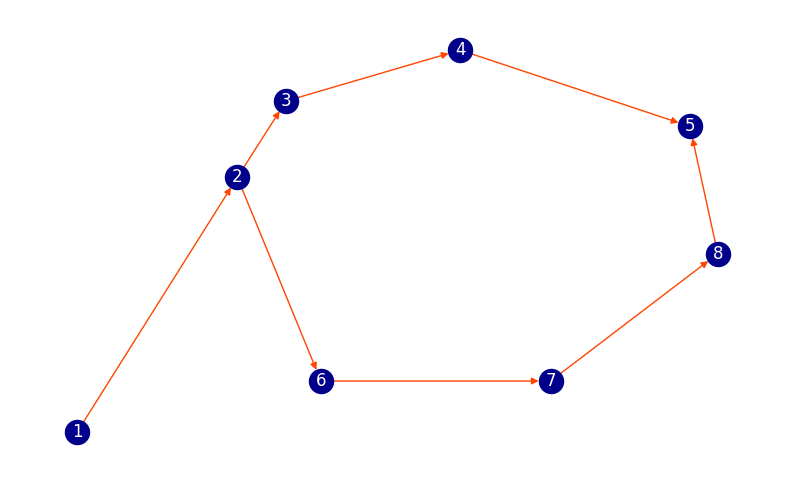

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
from matplotlib.patches import FancyArrowPatch
import numpy as np

# Create the graph and positions
G = nx.DiGraph()
G.add_edges_from([(1, 2), (2, 3), (3, 4), (4, 5), (2, 6), (6, 7), (7, 8), (8,5)])

d1 = {
    1: (-1000.00, 800.00),
    2: (1300.00, 1800.00),
    3: (2000.00, 2100.00),
    4: (4500.00, 2300.00),
    5: (7800.00, 2000.00),
    6: (2500.00, 1000.00),
    7: (5800.00, 1000.00),
    8: (8200.00, 1500.00)
}

pos = d1
# Draw nodes and normal edges
plt.figure(figsize=(10, 6))
nx.draw_networkx_nodes(G, pos, node_color='darkblue', node_size=300)
nx.draw_networkx_labels(G, pos, font_color='white')

# Draw straight edges except (5,7)
edges_to_draw = [(u, v) for u, v in G.edges if (u, v) != (5, 7)]
nx.draw_networkx_edges(G, pos, edgelist=edges_to_draw, edge_color='orangered', arrows=True)

# Draw curved edge from 5 to 7
start = np.array(pos[5])
end = np.array(pos[7])
control = (start + end) / 2 + np.array([-400, -600])  # Shift control point downward for curve

path = np.array([start, control, end])
codes = [1, 3, 3]  # MOVETO, CURVE3, CURVE3

curved_arrow = FancyArrowPatch(
    path=path, connectionstyle='arc3,rad=0.4',
    arrowstyle='-|>', color='orangered',
    linewidth=2
)
# plt.gca().add_patch(curved_arrow)

plt.axis('off')
# plt.title("Water Distribution Network with Curved Arc (5 → 7)")
plt.show()

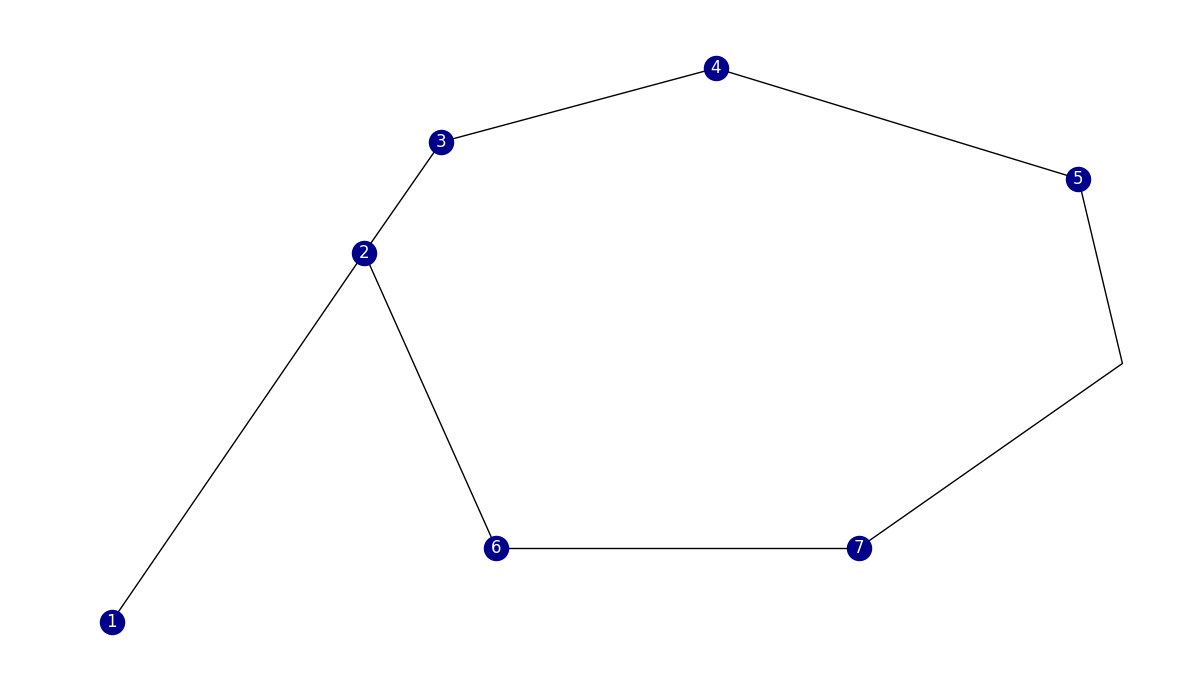

In [70]:
import matplotlib.pyplot as plt
import networkx as nx
from matplotlib.patches import FancyArrowPatch
from matplotlib.path import Path
import numpy as np

# Define the graph
G = nx.DiGraph()
G.add_edges_from([
    (1, 2), (2, 3), (3, 4), (4, 5),
    (2, 6), (6, 7),
    # Omit (7, 8) and (8, 5) from normal drawing; draw them manually
])

# Node positions (8 is hidden control point)
pos = {
    1: (-1000.00, 800.00),
    2: (1300.00, 1800.00),
    3: (2000.00, 2100.00),
    4: (4500.00, 2300.00),
    5: (7800.00, 2000.00),
    6: (2500.00, 1000.00),
    7: (5800.00, 1000.00),
    8: (8200.00, 1500.00)  # Hidden control node for visual path
}

# Plot
plt.figure(figsize=(12, 7))

# Draw visible nodes (excluding node 8)
visible_nodes = [n for n in G.nodes if n != 8]
nx.draw_networkx_nodes(G, pos, nodelist=visible_nodes, node_color='darkblue', node_size=300)
nx.draw_networkx_labels(G, pos, labels={n: str(n) for n in visible_nodes}, font_color='white')

# Draw normal edges
nx.draw_networkx_edges(G, pos, edgelist=G.edges(), edge_color='black', arrows=False)

# Manually draw a polyline from node 7 -> node 8 -> node 5
path_vertices = [pos[7], pos[8], pos[5]]
codes = [Path.MOVETO, Path.LINETO, Path.LINETO]
path = Path(path_vertices, codes)
arrow = FancyArrowPatch(
    path=path,
    arrowstyle='-|>',
    color='black',
    linewidth=1,
    mutation_scale=15
)
plt.gca().add_patch(arrow)

plt.axis('off')
plt.tight_layout()
plt.show()


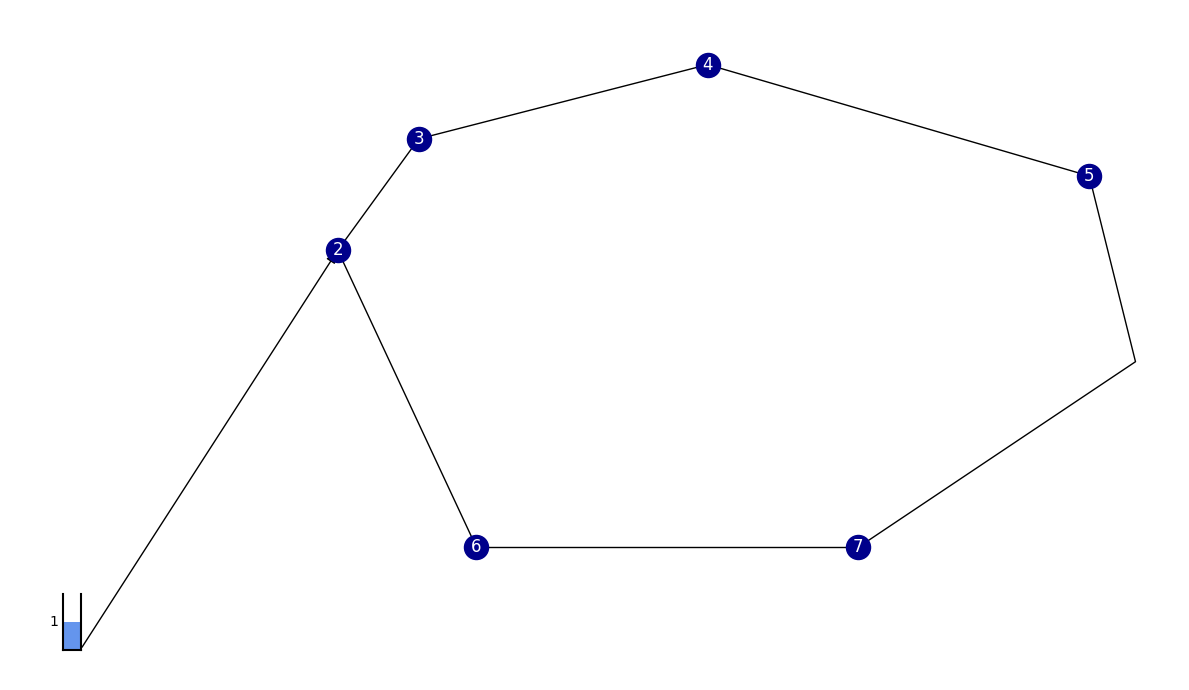

In [82]:
import matplotlib.pyplot as plt
import networkx as nx
from matplotlib.patches import FancyArrowPatch, Rectangle
from matplotlib.lines import Line2D
from matplotlib.path import Path

# Define the graph
G = nx.DiGraph()
G.add_edges_from([
    (1, 2), (2, 3), (3, 4), (4, 5),
    (2, 6), (6, 7),
])

# Node positions
pos = {
    1: (-1000.00, 800.00),
    2: (1300.00, 1800.00),
    3: (2000.00, 2100.00),
    4: (4500.00, 2300.00),
    5: (7800.00, 2000.00),
    6: (2500.00, 1000.00),
    7: (5800.00, 1000.00),
    8: (8200.00, 1500.00)
}

plt.figure(figsize=(12, 7))

# === 1. Draw smaller open tank at node 1 ===
tank_width, tank_height = 150, 150  # reduced size
tank_center = pos[1]
tank_x = tank_center[0] - tank_width / 2
tank_y = tank_center[1] - tank_height / 2

# Draw water (lower half filled)
water_height = tank_height / 2
water_fill = Rectangle((tank_x, tank_y), tank_width, water_height,
                       linewidth=0, edgecolor=None, facecolor='cornflowerblue', zorder=4)
plt.gca().add_patch(water_fill)

# Draw open tank (left, right, bottom only)
left_line = Line2D([tank_x, tank_x], [tank_y, tank_y + tank_height], color='black', linewidth=1.5, zorder=5)
right_line = Line2D([tank_x + tank_width, tank_x + tank_width], [tank_y, tank_y + tank_height], color='black', linewidth=1.5, zorder=5)
bottom_line = Line2D([tank_x, tank_x + tank_width], [tank_y, tank_y], color='black', linewidth=1.5, zorder=5)
plt.gca().add_line(left_line)
plt.gca().add_line(right_line)
plt.gca().add_line(bottom_line)

# Draw label "1" to the left of the tank
plt.text(tank_x - 40, tank_center[1], "1", fontsize=10, ha='right', va='center', color='black', zorder=6)

# Head label below the tank
# plt.text(tank_center[0], tank_center[1] - 130, "0.00", fontsize=10, ha='center', color='black')

# === 2. Manually draw edge from top-right corner of tank to node 2 ===
start_point = (tank_x + tank_width, tank_y )  # top-right corner of tank
end_point = pos[2]
arrow = FancyArrowPatch(posA=start_point, posB=end_point, arrowstyle='-|>', color='black', linewidth=1, mutation_scale=15)
plt.gca().add_patch(arrow)

# === 3. Draw other visible nodes (excluding 1 and 8) ===
visible_nodes = [n for n in G.nodes if n not in (1, 8)]
nx.draw_networkx_nodes(G, pos, nodelist=visible_nodes, node_color='darkblue', node_size=300)
nx.draw_networkx_labels(G, pos, labels={n: str(n) for n in visible_nodes}, font_color='white')

# === 4. Draw normal edges (excluding 1->2 and 7->8->5) ===
normal_edges = [(u, v) for u, v in G.edges if not (u == 1 and v == 2) and not (u == 7 and v == 8)]
nx.draw_networkx_edges(G, pos, edgelist=normal_edges, edge_color='black', arrows=False)

# === 5. Draw manual curve: node 7 -> node 8 -> node 5 ===
path_vertices = [pos[7], pos[8], pos[5]]
codes = [Path.MOVETO, Path.LINETO, Path.LINETO]
path = Path(path_vertices, codes)
arrow = FancyArrowPatch(
    path=path,
    arrowstyle='-|>',
    color='black',
    linewidth=1,
    mutation_scale=15
)
plt.gca().add_patch(arrow)

plt.axis('off')
plt.tight_layout()
plt.show()


In [141]:
import networkx as nx
from amplpy import AMPL
import matplotlib.pyplot as plt
import numpy as np
import time
import copy
import sys
import os
import contextlib
from sklearn.decomposition import PCA
import random

import matplotlib.lines as mlines
import matplotlib.patches as mpatches
from tabulate import tabulate
import optuna
import warnings
warnings.filterwarnings("ignore")
from pyswarm import pso
import multiprocessing


class WaterNetworkOptimizer:
    def __init__(self, model_file, data_file, data_number, data_list):
        self.ampl = AMPL()
        self.model_file = model_file
        self.data_list = data_list
        self.data_file = data_file
        self.data_number = data_number
        self.total_cost = None
        self.network_graph = None
        self.solve_result = None
        self.solver_time = 0
        self.best_acyclic_flow = None
        self.number_of_nlp = 0

    def load_model(self):
        """Load the model and data."""
        self.ampl.reset()
        self.ampl.read(self.model_file)
        self.ampl.read_data(self.data_file)
        
        self.nodes = self.ampl.getSet('nodes')
        self.source = self.ampl.getSet('Source')
        self.arcs = self.ampl.getSet('arcs')
        self.pipes = self.ampl.getSet('pipes')
        
        self.L = self.ampl.getParameter('L').to_dict()
        self.D = self.ampl.getParameter('D').to_dict()
        self.C = self.ampl.getParameter('C').to_dict()
        self.P = self.ampl.getParameter('P').to_dict()
        self.R = self.ampl.getParameter('R').to_dict()
        self.E = self.ampl.getParameter('E').to_dict()
        self.d = self.ampl.getParameter('d').to_dict()
        self.eps = self.ampl.getParameter('eps').to_dict()
        
        
        self.delta = 0.1
        self.p = 1.852
        self.omega = 10.67

    def create_digraph(self):
        nodes_list = [i for i in self.ampl.getSet('nodes')]
        edges_list = self.ampl.getSet('arcs').to_list()
        self.network_graph = nx.DiGraph()
        self.network_graph.add_nodes_from(nodes_list)
        self.network_graph.add_edges_from(edges_list)
        print(nodes_list)
        print(edges_list)

    def display_results(self):
        """Display relevant results from the optimization."""
        self.ampl.eval("display {(i,j) in arcs, k in pipes:l[i,j,k]>1} l[i,j,k];")
        self.ampl.eval("display {(i,j) in arcs}: q[i,j];")
        self.ampl.eval("display h;")
        self.ampl.eval("display solve_result;")
        self.total_cost = self.ampl.get_objective("total_cost").value()
        print("Objective:", self.total_cost)
        # self.ampl.eval("display {(i,j) in arcs} h[i] - h[j];")
        # self.ampl.eval("display {i in nodes} h[i] - (E[i] + P[i]);")

    # def plot_graph(self):
    #     print("Edges of the graph:",self.network_graph.edges())
    #     plt.figure(figsize=(10, 8))
    #     nx.draw_spectral(self.network_graph, with_labels=True)
    #     plt.show()


    def plot_graph1(self, super_source_out_arc=None, best_arc=None,current_cost = None, iteration= 1):
        # print("Edges of the graph:", self.network_graph.edges())
        indegree_2_or_more = [node for node, indeg in self.network_graph.in_degree() if indeg >= 2]
        
        plt.figure(figsize=(10, 8))
        pos = nx.spectral_layout(self.network_graph)
        nx.draw_networkx_nodes(self.network_graph, pos, node_color='lightblue', node_size=200)
        
        if indegree_2_or_more:
            nx.draw_networkx_nodes(self.network_graph, pos, nodelist=indegree_2_or_more, node_color='orange', node_size=200)
            
        nx.draw_networkx_labels(self.network_graph, pos)
        nx.draw_networkx_edges(self.network_graph, pos, edge_color='black')
        
        if super_source_out_arc:
            nx.draw_networkx_edges(self.network_graph, pos, edgelist=super_source_out_arc, edge_color='red', width=1)
            
        if best_arc:
            nx.draw_networkx_edges(self.network_graph, pos, edgelist=[best_arc], edge_color='magenta', width=1)
            
        plt.title(f"total_cost:{self.total_cost}")
        plt.savefig(f"/home/nitishdumoliya/waterNetwork/model/figure/d{self.data_number}_iteration_{iteration}.png")
        plt.box(False)
        plt.show()

    def plot_graph(self, super_source_out_arc=None, current_cost = None, iteration = 1, edge_weights= None, h = None, D = None, arc=(0,0), l ={}, C = {}):
        # self.network_graph = nx.DiGraph()
        # self.network_graph.add_edges_from(edges)
        # Node positions as per your specifications
        
        node_coordinate_d1 = {
             2 : (2000.00, 3000.00),
             3 : (1000.00, 3000.00),        
             4 : (2000.00, 2000.00),        
             5 : (1000.00, 2000.00),       
             6 : (2000.00, 1000.00),       
             7 : (1000.00, 1000.00),      
             1 : (3000.00, 3000.00)     
            }  
        
        node_coordinate_d2 = {
            2: (6000.00, 2000.00),
            3: (6000.00, 4000.00),
            4: (7500.00, 4000.00),
            5: (9000.00, 4000.00),
            6: (10000.00, 4000.00),
            7: (10000.00, 6000.00),
            8: (10000.00, 8000.00),
            9: (10000.00, 10000.00),
            10: (9000.00, 10000.00),
            11: (9000.00, 11500.00),
            12: (9000.00, 13000.00),
            13: (7000.00, 13000.00),
            14: (8000.00, 10000.00),
            15: (7000.00, 10000.00),
            16: (6000.00, 10000.00),
            17: (6000.00, 8500.00),
            18: (6000.00, 7000.00),
            19: (6000.00, 5500.00),
            20: (4500.00, 4000.00),
            21: (4500.00, 2000.00),
            22: (4500.00, 0.00),
            23: (3000.00, 4000.00),
            24: (3000.00, 7000.00),
            25: (3000.00, 10000.00),
            26: (4000.00, 10000.00),
            27: (5000.00, 10000.00),
            28: (1500.00, 4000.00),
            29: (0.00, 4000.00),
            30: (0.00, 7000.00),
            31: (0.00, 10000.00),
            32: (1500.00, 10000.00),
            1: (8000.00, 0.00)
        }       
        
        node_coordinate_d16 = {
            2: (5679.61, 9538.83),
            3: (4862.46, 9538.83),
            4: (2750.81, 9474.11),
            5: (1852.75, 8357.61),
            6: (1974.11, 6076.05),
            7: (1974.11, 5149.68),
            8: (4235.44, 5076.86),
            9: (6411.81, 5093.04),
            10: (5412.62, 7888.35),
            11: (4510.52, 8264.56),
            12: (3033.98, 9243.53),
            13: (2301.78, 8078.48),
            14: (2944.98, 7669.90),
            15: (3786.41, 7139.97),
            16: (4830.10, 6480.58),
            17: (7099.51, 8438.51),
            18: (5505.66, 8450.65),
            19: (3563.92, 8839.00),
            20: (3167.48, 7532.36),
            21: (2730.58, 7285.60),
            22: (3511.33, 6666.67),
            23: (4097.90, 6286.41),
            24: (3337.38, 5121.36),
            25: (4530.74, 6011.33),
            26: (4215.21, 7783.17),
            27: (5194.17, 7055.02),
            28: (5218.45, 5089.00),
            29: (5622.98, 5999.19),
            30: (5950.65, 5796.93),
            31: (6614.08, 7621.36),
            32: (5380.26, 7544.50),
            33: (6318.77, 7281.55),
            34: (6549.35, 7212.78),
            35: (6585.76, 6092.23),
            36: (7152.10, 6104.37),
            1: (7111.65, 7532.36),
            37: (7669.90, 7783.17)
        }

        # # Update node positions
        pos = node_coordinate_d1
        # pos = nx.spectral_layout(self.network_graph)

        cost = {}

        for (i,j) in self.ampl.getSet('arcs'):
            cost[i,j] = sum(l[i,j,k] * C[k] for k in self.pipes)
        
        plt.figure(figsize=(10, 8))
        # plt.figure(figsize=(15, 11))
        cmap = plt.cm.plasma
        network_graph = self.generate_random_acyclic_from_solution(edge_weights)
        nx.draw_networkx_nodes(network_graph, pos, node_color='lightblue',edgecolors="black", node_size=300,linewidths=0.5, label='Regular Nodes')
        
        indegree_2_or_more = [node for node, indeg in network_graph.in_degree() if indeg >= 2]
        if indegree_2_or_more:
            nx.draw_networkx_nodes(network_graph, pos, nodelist=indegree_2_or_more, node_color='orange',edgecolors="orange", node_size=300, label='Nodes with In-Degree ≥ 2')
        
        # nx.draw_networkx_nodes(self.network_graph, pos, nodelist=list(self.source), node_color='cornflowerblue',edgecolors="black", node_size=300,linewidths=0.5, label='Source node')
        # if not self.visited_nodes:
        #     nx.draw_networkx_nodes(self.network_graph, pos, nodelist=indegree_2_or_more, node_color='orange',edgecolors="black", node_size=300,linewidths=0.5, label='Nodes with In-Degree ≥ 2')
            
        # if self.sorted_nodes:
        #     nx.draw_networkx_nodes(self.network_graph, pos, nodelist=self.sorted_nodes, node_color='orange',edgecolors="black", node_size=300,linewidths=0.5, label='Visited nodes')
            
        # if self.visited_nodes:
        #     visited_nodes = [item for item in  self.visited_nodes if item in self.indegree_2_or_more]
        #     nx.draw_networkx_nodes(self.network_graph, pos, nodelist=visited_nodes, node_color='violet',edgecolors="black", node_size=300,linewidths=0.5, label='Sorted nodes')

        
        nx.draw_networkx_labels(network_graph, pos, font_size=10)
        
        nx.draw_networkx_edges(network_graph, pos, arrowstyle="->", arrowsize=12, edge_color='black', label='Regular Arcs', arrows=True) # arrows=False

        if super_source_out_arc:
            nx.draw_networkx_edges(network_graph, pos, edgelist=super_source_out_arc,arrowstyle="->", arrowsize=12, edge_color='red', width=1, label='Fix arc direction')
        
        # if best_arc:
        #     nx.draw_networkx_edges(self.network_graph, pos, edgelist=[best_arc],arrowstyle="->", arrowsize=12, edge_color='magenta', width=1, label = 'Best arc')
        # Annotate node demands
        if h:
            for node, (x, y) in pos.items():
                demand = h.get(node, 0)  # Get the head for the node, default to 0 if not in dictionary
                # plt.text(x, y + 120, f"{demand:.2f}", fontsize=8, color='blue', ha='center')  # Annotate demand below the node
                # plt.text(x, y + 200, f"{demand:.2f}", fontsize=8, color='blue', ha='center')  # Annotate demand below the node
                # plt.text(x, y -100 , f"{demand:.2f}", fontsize=8, color='magenta', ha='center')  # Annotate demand below the node
                # plt.text(mid_x, mid_y + 50 , f"{weight:.2f}", fontsize=8, color='green', ha='center')  # Annotate weight on edge
                # plt.text(mid_x, mid_y + 100, f"{value:.2f}", fontsize=8, color='green', ha='center')  # Annotate weight on edge
        if D:
            for node, (x, y) in pos.items():
                demand = D.get(node, 0)  # Get the demand for the node, default to 0 if not in dictionary
                # plt.text(x-250, y - 400, f"{demand*1000:.2f}", fontsize=10, color='black', ha='center')  # Annotate demand below the node
                plt.text(x-80, y - 130 , f"{demand:.2f}", fontsize=10, color='magenta', ha='center')  # Annotate demand below the node
            
        if edge_weights:
            for (u, v), weight in edge_weights.items():
                # if self.network_graph.has_edge(u, v):
                mid_x = (pos[u][0] + pos[v][0]) / 2  # Midpoint x-coordinate
                mid_y = (pos[u][1] + pos[v][1]) / 2  # Midpoint y-coordinate
                # plt.text(mid_x+270, mid_y+180 , f"{weight:.2f}", fontsize=10, color='black', ha='center')  # Annotate weight on edge
                plt.text(mid_x+150, mid_y + 80 , f"{weight*1000:.2f}", fontsize=10, color='black', ha='center')  # Annotate weight on edge
        # if cost:
        #     for (u, v), value in cost.items():
        #         # if self.network_graph.has_edge(u, v):
        #         mid_x = (pos[u][0] + pos[v][0]) / 2  # Midpoint x-coordinate
        #         mid_y = (pos[u][1] + pos[v][1]) / 2  # Midpoint y-coordinate
                # plt.text(mid_x, mid_y-300 , f"{round(value)}", fontsize=8, color='purple', ha='center')  # Annotate weight on edge
                # plt.text(mid_x, mid_y + 100, f"{value:.2f}", fontsize=8, color='green', ha='center')  # Annotate weight on edge
        pipe_dia_arc = {}
        for (i,j) in self.arcs:
            list_=[]
            for k in self.pipes:
                if l[i,j,k]>= 1e-5:
                    list_.append(k)
            pipe_dia_arc[i,j] = list_
        
        if pipe_dia_arc:
            for (u, v), weight in pipe_dia_arc.items():
                # if self.network_graph.has_edge(u, v):
                mid_x = (pos[u][0] + pos[v][0]) / 2  # Midpoint x-coordinate
                mid_y = (pos[u][1] + pos[v][1]) / 2  # Midpoint y-coordinate
                plt.text(mid_x - 100, mid_y - 100 , f"{weight}", fontsize=10, color='purple', ha='center')  # Annotate weight on edge
                # plt.text(mid_x-250, mid_y+120 , f"{weight}", fontsize=11, color='#006400', ha='center')  # Annotate weight on edge
        
        regular_node_patch = mpatches.Patch(color='lightblue', label='Regular Nodes')
        indegree_node_patch = mpatches.Patch(color='orange', label='Nodes with In-Degree ≥ 2')
        regular_edge_line = mlines.Line2D([], [], color='black', label='Regular Arcs')
        super_source_edge_line = mlines.Line2D([], [], color='red', label='Fix arc direction')
        # best_edge_line = mlines.Line2D([], [], color='magenta', label='Best Arc')
        # plt.legend(handles=[regular_node_patch, indegree_node_patch, regular_edge_line, super_source_edge_line], loc='lower right')
        
        cost = round(current_cost)
        # res = f"{cost:,}"
        plt.title(f"Total cost: {self.format_indian_number(cost)}")
        # (u,v) = arc
        plt.savefig(f"/home/nitishdumoliya/waterNetwork/wdnd/figure/newfigure/d{self.data_number}_iteration_{iteration}.png")
        plt.box(False)
        plt.show()

    
    def cycle_basis(self):
        root = self.ampl.getSet('Source').to_list()[0]
        nodes_list = [i for i in self.ampl.getSet('nodes')]
        edges_list = self.ampl.getSet('arcs').to_list() 
        uwg = nx.Graph()
        uwg.add_nodes_from(nodes_list)
        uwg.add_edges_from(edges_list)
        # print("Edges in the undirected graph:", edges_list)
        print("cycle basis for given water network: ",nx.cycle_basis(uwg, root))
        
    def generate_random_acyclic_from_solution(self, q):
        # print("Generate the acyclic network using ipopt solution")
        
        self.network_graph = nx.DiGraph()
        self.network_graph.add_nodes_from(self.nodes)
        
        # q = self.ampl.getVariable('q').getValues().toDict()
        for (i,j) in self.arcs:
            if q[i,j] >= 0:
                self.network_graph.add_edge(i,j)
            else:
                self.network_graph.add_edge(j,i)
        
        return self.network_graph

    
    def generate_random_acyclic_graph(self):
        uwg = nx.Graph()
        nodes_list = [i for i in self.ampl.getSet('nodes')]
        edges_list = self.ampl.getSet('arcs').to_list()
        uwg.add_nodes_from(nodes_list)
        uwg.add_edges_from(edges_list)
        print("Edges in the undirected graph:", edges_list)
        
        # Generate a random spanning tree using Wilson's algorithm
        random_tree = nx.random_spanning_tree(uwg)
        
        # Retrieve the root from the AMPL source set
        root_l = self.ampl.getSet('Source').to_list()
        root = root_l[0]
        print("Root node:", root)

        # Ensure the root is present in the random tree
        if root not in random_tree.nodes:
            raise ValueError("The specified root must be a node in the graph.")

        # Create a directed graph from the random tree starting from the specified root
        self.network_graph = nx.DiGraph()
        visited = set()

        def dfs(node):
            visited.add(node)
            for neighbor in random_tree.neighbors(node):
                if neighbor not in visited:
                    self.network_graph.add_edge(node, neighbor) 
                    dfs(neighbor)

        # Start DFS from the specified root
        dfs(root)

        # Draw the initial directed tree
        plt.figure(figsize=(15, 10))
        plt.subplot(121)
        nx.draw_spectral(self.network_graph, with_labels=True, node_color='lightgreen', font_weight='bold', arrows=True)
        plt.title("Directed Spanning Tree")

        # Add remaining edges from the original graph and check for cycles
        for u, v in uwg.edges():
            if not self.network_graph.has_edge(u, v):  
                self.network_graph.add_edge(u, v)  
                if not nx.is_directed_acyclic_graph(self.network_graph):  
                    self.network_graph.remove_edge(u, v)  
                    self.network_graph.add_edge(v, u)  

        # Draw the final directed graph after adding remaining edges
        plt.subplot(122)
        nx.draw_spectral(self.network_graph, with_labels=True, node_color='lightgreen', font_weight='bold', arrows=True)
        plt.title("Acyclic Directed Graph")
        plt.show()

    def update_model(self):
        # print("Fix the arcs direction using the acyclic network\n")
        edges_list = [(arc[0],arc[1]) for arc in self.ampl.getSet('arcs')]
        for edge in self.network_graph.edges:
            i, j = edge
            if edge in edges_list:
                self.ampl.eval(f"s.t. flow_direction{i}_{j}: q[{i},{j}] >=0;")
                # self.ampl.eval(f"s.t. head_bound_left{i}_{j}: E[{j}]+P[{j}] <= h[{j}];")
                # self.ampl.eval(f"s.t. head_bound_right{i}_{j}: E[{j}] + P[{j}] <= h[{i}];")
            else:
                self.ampl.eval(f"s.t. flow_direction{i}_{j}: q[{j},{i}] <=0;")
                # self.ampl.eval(f"s.t. head_bound_left{i}_{j}: E[{i}]+P[{i}] <= h[{i}];")
                # self.ampl.eval(f"s.t. head_bound_right{i}_{j}: E[{i}] + P[{i}] <= h[{j}];")  


    def is_valid_edge(self, source, target):
        """Check if adding the directed edge (source -> target) maintains acyclicity."""
        self.network_graph.add_edge(source, target)  # Temporarily add the edge
        is_dag = nx.is_directed_acyclic_graph(self.network_graph)  # Check for acyclicity
        self.network_graph.remove_edge(source, target)  # Remove the edge after checking
        return is_dag  # Return True if it maintains acyclicity     
    
    def check_incoming_arcs(self):
        root = list(self.ampl.getSet('Source'))[0]
        # Iterate over all nodes in the graph
        for node in self.network_graph.nodes():
            # Skip the root node
            if node == root:
                continue
            # Check if the in-degree of the node is at least 1
            if self.network_graph.in_degree(node) < 1:
                # print(f"Node {node} does not have any incoming arcs.")
                return False
        # print("All nodes except the root have at least one incoming arc.")
        return True
            
    def format_indian_number(self,num):
        num_str = str(num)
        if len(num_str) <= 3:
            return num_str
        else:
            # Split the number into the last three digits and the rest
            last_three = num_str[-3:]
            remaining = num_str[:-3]
            # Add commas every two digits in the remaining part
            remaining = ','.join([remaining[max(i - 2, 0):i] for i in range(len(remaining), 0, -2)][::-1])
            return remaining + ',' + last_three

    def fix_leaf_arc_flow(self):
        graph = nx.Graph()
        arc_set = self.ampl.getSet('arcs').to_list()  
        graph.add_edges_from(arc_set)
        D = self.ampl.getParameter('D').getValues().to_dict()  
        source = self.ampl.getSet('Source').to_list()[0]
        fixed_arcs = set()
        # print("\nPresolve the model for fixing the flow value in the leaf arcs")
        # print("Source:",self.ampl.getSet('Source').to_list())

        while True:
            leaf_nodes = [node for node in graph.nodes if graph.degree[node] == 1]
            # print("leaf_nodes:", leaf_nodes)
            if not leaf_nodes:  
                break

            for leaf in leaf_nodes:
                neighbor = next(graph.neighbors(leaf))
                if (neighbor, leaf) in arc_set:
                    edge = (neighbor, leaf)
                    if edge not in fixed_arcs:  
                        if leaf == source:
                            flow_value = D[leaf]
                            D[neighbor] = (D[neighbor]+flow_value)
                            source = neighbor
                        else:
                            flow_value = D[leaf]
                            D[neighbor] = D[neighbor] + flow_value
                        #self.ampl.eval(f"s.t. fix_q_{edge[0]}_{edge[1]}: q[{edge[0]},{edge[1]}] = {flow_value};")
                        # print(f"Fixing flow for arc {edge}: {flow_value}")
                        fixed_arcs.add(edge)  

                    graph.remove_node(leaf)
                else:
                    edge = (leaf, neighbor)
                    if edge not in fixed_arcs:  
                        if leaf == source:
                            flow_value = -D[leaf]
                            D[neighbor] = D[neighbor]-flow_value
                            source = neighbor
                            #self.ampl.eval(f"s.t. fix_q_{edge[0]}_{edge[1]}: q[{edge[0]},{edge[1]}] = {flow_value};")
                        elif neighbor == source:
                            flow_value = -D[leaf]
                            D[neighbor] = D[neighbor] - D[leaf] 
                            #self.ampl.eval(f"s.t. fix_q_{edge[0]}_{edge[1]}: q[{edge[0]},{edge[1]}] = {flow_value};")
                        else:
                            flow_value = -D[leaf]
                            D[neighbor] += -flow_value
                            #self.ampl.eval(f"s.t. fix_q_{edge[0]}_{edge[1]}: q[{edge[0]},{edge[1]}] = {flow_value};")
                        # priqnt(f"Fixing flow for arc {edge}: {flow_value}")
                        fixed_arcs.add(edge)  
                    graph.remove_node(leaf)
        # print("All leaf arc flows have been fixed.")
        return fixed_arcs

    def is_cycle(self, graph, start_node, end_node, visited_copy, parent):
        visited_copy[start_node] = True
        # print(f"Is node {end_node} in cycle?")
        for neighbor in graph.neighbors(start_node):
            # print("visited",neighbor,visited_copy[neighbor])
            if not visited_copy[neighbor]:
                # print("neighbor of node", start_node, "is", neighbor)
                isCycle = self.is_cycle(graph, neighbor, end_node, visited_copy, start_node)
                if isCycle:
                    return True
            else:
                # print("parent:", parent)
                if parent != neighbor:
                    if end_node == neighbor:
                        # print(f"Node {end_node} is in cycle")
                        return True
        return False

    def presolve(self, graph, node, visited, parent, set_arc):
        visited_copy = visited.copy()
        # print(visited_copy)
        isCycle = self.is_cycle(graph, node, node, visited_copy, parent)
        # print(f"Is node {node} in cycle?",isCycle)
        visited[node] = True
        if isCycle:
            for neighbor in graph.neighbors(node):
                if parent!=neighbor:
                    set_arc.append((node,neighbor))
                    # print("Fix the arc", (node, neighbor))
            return set_arc
        else:
            for neighbor in graph.neighbors(node):
                if parent != neighbor:
                    set_arc.append((node,neighbor))
                    # print(set_arc)
                    # print("Fix the arc", (node, neighbor))
                    # print("neighbor:", neighbor)
                    self.presolve(graph, neighbor, visited, node, set_arc)
        return set_arc

    def fix_arc_set(self):
        graph = nx.Graph()
        arc_set = self.ampl.getSet('arcs').to_list()
        graph.add_edges_from(arc_set)
        visited = {node: False for node in graph.nodes()}
        source = self.ampl.getSet('Source').to_list()[0]
        set_arc = []
        # print("\nPresolve the model for fixing the arc direction")
        set_ = self.presolve(graph, source, visited, -1, set_arc)
        # print("fixed arc direction:",set_, "\n") 
        return set_

    def update_initial_points(self,edge, l_solution, q_solution, h_solution):
        for (i, j, k), val in l_solution.items():
            self.ampl.eval(f'let l[{i},{j},{k}] := {val};')
        for (i, j), val in q_solution.items():
            #if (i,j) != edge:
            self.ampl.eval(f'let q[{i},{j}] := {val};')
            #else:
            #    self.ampl.eval(f'let q[{i},{j}] := {-val};')
        for i, val in h_solution.items():
            self.ampl.eval(f'let h[{i}] := {val};')

    def update_initial_points1(self,l_solution, q_solution, h_solution, inarc):
        for (i, j, k), val in l_solution.items():
            self.ampl.eval(f'let l[{i},{j},{k}] := {val};')
        
        edge_list_network = self.network_graph.edges
        
        for i, val in h_solution.items():
            self.ampl.eval(f'let h[{i}] := {val};')
        
        for (i, j), val in q_solution.items():
            edge = (i, j)
            if edge in edge_list_network:
                 
                if (i,j) not in inarc:
                    # print(f"self.ampl.eval(let q[{i},{j}] := {val};)")
                    self.ampl.eval(f"let q[{i},{j}] := {val} ;")
                else:
                    # print(f"self.ampl.eval(let q[{i},{j}] := {-val};)")
                    self.ampl.eval(f"let q[{i},{j}] := {val} ;")
            else:
                if (j,i) not in inarc:
                    # print(f"self.ampl.eval(let q[{i},{j}] := {val};)")
                    self.ampl.eval(f"let q[{i},{j}] := {val};")
                else:
                    # print(f"self.ampl.eval(let q[{j},{i}] := {-val};)")
                    self.ampl.eval(f"let q[{j},{i}] := {val} ;")
        
        # current_duals = {}
        # for con_name, val in self.ampl.get_constraints():
        #     dual_values = val.get_values()
        #     current_duals[con_name] = dual_values

        # Initialize dual values for all constraints
        # for con_name, dual_values in all_duals.items():
            # if con_name in current_duals:
                # Initialize dual values for each constraint
                # self.ampl.get_constraint(con_name).set_values(dual_values)
            # else:
            #     print(f"Skipping initialization for constraint: {con_name} (not in current model)")
    
    def update_initial_points_with_perturbation(self, l_solution, q_solution, h_solution,all_duals, inarc, delta=0.1):
        edge_list_network = self.network_graph.edges
        L = self.ampl.getParameter('L').getValues().to_dict()
        # Perturb l values
        for (i, j, k), val in l_solution.items():
            if (i,j) not in inarc:
                if val>= 1e-5:
                    perturbation = random.gauss(0, 1)
                    new_val = val + perturbation
                    # if val >= 1e-5:
                    self.ampl.eval(f'let l[{i},{j},{k}] := {new_val};')
                else:
                    self.ampl.eval(f'let l[{i},{j},{k}] := {0};')
            else:
                if val>= 1e-5:
                    perturbation = random.gauss(0, 1)
                    new_val = val + perturbation
                    self.ampl.eval(f'let l[{i},{j},{k}] := {new_val};')
                else:
                    self.ampl.eval(f'let l[{i},{j},{k}] := {0};')
                    
        # Perturb h values
        for i, val in h_solution.items():
            perturbation = random.gauss(0, 1)
            new_val = val + perturbation
            self.ampl.eval(f'let h[{i}] := {new_val};')

        # Modify q values based on heuristic
        for (i, j), val in q_solution.items():
            edge = (i, j)
            perturbation = random.gauss(0, 1)
            if edge in edge_list_network:
                if (i, j) not in inarc:
                    self.ampl.eval(f"let q[{i},{j}] := {val + perturbation};")
                else:
                    self.ampl.eval(f"let q[{i},{j}] := {(val + perturbation)};")
            else:
                if (j, i) not in inarc:
                    self.ampl.eval(f"let q[{i},{j}] := {val + perturbation};")
                else:
                    self.ampl.eval(f"let q[{j},{i}] := {(val + perturbation)};")
        
        current_duals = {}
        for con_name, val in self.ampl.get_constraints():
            dual_values = val.get_values()
            current_duals[con_name] = dual_values

        # Initialize dual values for all constraints
        for con_name, dual_values in all_duals.items():
            if con_name in current_duals:
                # Initialize dual values for each constraint
                self.ampl.get_constraint(con_name).set_values(dual_values)

    def multistart(self, inarc, current_cost, best_acyclic_flow, improved, super_source_out_arc, iteration):
        improved = False
        max_l = max(self.ampl.getParameter('L').to_dict().values())
        max_q = self.ampl.getParameter('D').getValues().toDict()
        # print(max_q[1])
        # for i, value in max_q.items():
        #     print(value)
        
        source = self.ampl.getSet('Source').to_list()
        E = self.ampl.getParameter('E').getValues().toDict()
        P = self.ampl.getParameter('P').getValues().toDict()
        
        # Define the number of starts for multistart heuristic
        num_starts = 10
        
        # Set a random seed for reproducibility
        random.seed(num_starts)
        
        # Loop for multistart heuristic
        for start in range(num_starts):
            
            for (i,j) in self.arcs:
                for k in self.pipes:
                    value = random.uniform(0, max_l)  
                    self.ampl.eval(f' let l[{i},{j},{k}] := {self.l[i,j,k]};')

            for (i,j) in self.network_graph.edges:
                if (i,j) not in inarc:
                    if (i,j) in self.arcs:
                        value = random.uniform(0, -max_q[1])
                        self.ampl.eval(f'let q[{i},{j}] := {value};')
                    else:
                        value = random.uniform(max_q[1], 0)
                        self.ampl.eval(f'let q[{j},{i}] := {value};')
                else:
                    if (i,j) in self.arcs:
                        value = random.uniform(0, -max_q[1])
                        self.ampl.eval(f'let q[{i},{j}] := {value};')
                    else:
                        value = random.uniform(max_q[1], 0)
                        self.ampl.eval(f'let q[{j},{i}] := {value};')

            # for (i,j) in self.ampl.get_set("arcs").to_list():
            #     value = random.uniform(max_q[1], -max_q[1])  
            #     self.ampl.eval(f'let q[{i},{j}] := {value};')
            for i in self.nodes:
                value = random.uniform(E[i]+P[i], E[source[0]])  
                self.ampl.eval(f'let h[{i}] := {self.h[i]};')

            self.ampl.set_option("solver", "ipopt")
            self.ampl.set_option("ipopt_options", "outlev = 0 expect_infeasible_problem = yes bound_push = 0.001 bound_frac = 0.001 warm_start_init_point = yes")
            # ampl.option[""]
            self.ampl.solve()

            if self.ampl.solve_result == 'solved':
                cost = self.ampl.get_objective("total_cost").value()
                print(cost)
                # Update the best solution if the current cost is lower
                if cost < current_cost:
                    improved = True
                    current_cost = cost
                    self.generate_random_acyclic_from_solution()
                    best_acyclic_flow = self.network_graph.copy()
                    l = self.ampl.getVariable('l').getValues().to_dict()
                    q = self.ampl.getVariable('q').getValues().to_dict()
                    h = self.ampl.getVariable('h').getValues().to_dict()
                    D = self.ampl.getParameter('D').getValues().to_dict()
                    self.plot_graph(super_source_out_arc, current_cost, iteration, q, h, D)
                    # print(best_acyclic_flow, improved, current_cost, l, q, h)
                # else:
                #     pass
        if improved:
            return best_acyclic_flow, improved, current_cost, l, q, h
        else:
            return self.best_acyclic_flow, improved, current_cost, self.l, self.q, self.h
                    
        # return best_acyclic_flow, improved, current_cost, l, q, h

    def acyclic_arcs(self):
        network_graph = self.best_acyclic_flow
        indegree_2_or_more = [node for node, indeg in network_graph.in_degree() if indeg >= 2]
        acyclic_arc = set()
        for node in indegree_2_or_more:
            # print("Node:", node,"in_degree:", self.network_graph.in_degree(node))
            for edge in list(network_graph.in_edges(node)):
                (u, v) = edge
                if (u,v) not in self.super_source_out_arc :
                    network_graph.remove_edge(u,v)
                    network_graph.add_edge(v,u)
                    acy_check = nx.is_directed_acyclic_graph(network_graph)
                    in_arc_check = self.check_incoming_arcs()
                    # print("Acyclic", acy_check and in_arc_check)
                    if acy_check and in_arc_check:
                        acyclic_arc.add((u,v))
                        # if (u,v) in self.arcs:
                        #     acyclic_arc.add((u,v))
                        # else:
                        #     acyclic_arc.add((v,u))

                    network_graph.remove_edge(v, u)
                    network_graph.add_edge(u, v)
        return acyclic_arc
    
    def constraint_violations(self, q_values, h_values, l_values, epsilon, solver):
        total_absolute_constraint_violation = 0
        total_relative_constraint_violation = 0
         
        con1_gap = {}
        if self.data_number==5:
            q1 = self.ampl.get_variable('q1').get_values().to_dict()
            q2 = self.ampl.get_variable('q2').get_values().to_dict()
            for i in self.nodes:
                if i not in self.source:
                    con1_rhs = self.D[i]
                    incoming_flow = sum(q1[j, i] + q2[j,i] for j in self.nodes if (j, i) in self.arcs)
                    outgoing_flow = sum(q1[i, j] + q2[i,j] for j in self.nodes if (i, j) in self.arcs)
                    con1_lhs = incoming_flow - outgoing_flow
                    con1_violation = con1_lhs - con1_rhs
                    con1_gap[f"{i}"] = con1_violation
                    total_absolute_constraint_violation += abs(con1_violation)
        else:
            for i in self.nodes:
                if i not in self.source:
                    con1_rhs = self.D[i]
                    incoming_flow = sum(q_values[j, i] for j in self.nodes if (j, i) in self.arcs)
                    outgoing_flow = sum(q_values[i, j] for j in self.nodes if (i, j) in self.arcs)
                    con1_lhs = incoming_flow - outgoing_flow
                    con1_violation = con1_lhs - con1_rhs
                    con1_gap[f"{i}"] = con1_violation
                    total_absolute_constraint_violation += abs(con1_violation)
        #print("con1_gap:", con1_gap) 
        con2_original_gap = {}
        con2_approx_gap = {}
        absolute_violations = {}
        relative_violations = {}
        con2_absolute_constraint_violation = 0
        con2_relative_constraint_violation = 0
        con2_original_violation = 0
        con2_approx_violation = 0

        if self.data_number==5:
            #q1 = self.ampl.get_variable('q1').get_values().to_dict()
            #q2 = self.ampl.get_variable('q2').get_values().to_dict()
            self.exdiam = self.ampl.getParameter('exdiam').to_dict()
            for (i, j) in q1.keys():
                # Original constraint value
                lhs = 2*(h_values[i] - h_values[j])
                alpha_rhs = sum(10.67 * l_values[i, j, k] / ((self.R[i,j] ** 1.852) * ((self.d[k]) ** 4.87)) for k in self.pipes)
                #alpha_rhs = sum(10.67 * l_values[i, j, k] / ((self.R[k] ** 1.852) * ((self.d[k]) ** 4.87)) for k in self.pipes)
                original_rhs = q1[i, j] * (abs(q1[i, j])) ** 0.852 * 10.67 * self.L[i,j]/(self.R[i,j]**1.852 * self.exdiam[i,j]**4.87) + q2[i, j] * (abs(q2[i, j])) ** 0.852 * alpha_rhs  
                #original_rhs =  q_values[i, j] * (abs(q_values[i, j])) ** 0.852 * alpha_rhs
                # Approximated constraint value
                approx_rhs = (q1[i, j]**3 * ((q1[i, j]**2 + epsilon[i,j]) ** 0.426)/(q1[i,j]**2 + 0.426*epsilon[i,j])) * 10.67 * self.L[i,j]/(self.R[i,j]**1.852 * self.exdiam[i,j]**4.87) + (q2[i, j]**3 * ((q2[i, j]**2 + epsilon[i,j]) ** 0.426)/(q2[i,j]**2 + 0.426*epsilon[i,j])) * alpha_rhs

                #approx_rhs = (q_values[i, j]**3 * ((q_values[i, j]**2 + 1e-12) ** 0.426)/(q_values[i,j]**2 + 0.426*1e-12))*alpha_rhs
                con2_original_gap[f"{i},{j}"] = lhs - original_rhs
                con2_original_violation += abs(lhs - original_rhs) 
                con2_approx_gap[f"{i},{j}"] = lhs - approx_rhs 
                total_absolute_constraint_violation += abs(lhs - approx_rhs)    
                con2_approx_violation += abs(lhs - approx_rhs) 

                # Compute absolute violation
                absolute_violation =  original_rhs - approx_rhs
                absolute_violations[f"{i},{j}"] = absolute_violation
                con2_absolute_constraint_violation += abs(absolute_violation)

                # Compute relative violation between original_rhs and approx_rhs
                relative_violation = (original_rhs - approx_rhs) / (original_rhs+1e-14)
                relative_violations[f"{i},{j}"] = relative_violation
                con2_relative_constraint_violation += abs(relative_violation)

        elif self.data_number==6:
            self.fixarcs = self.ampl.getSet('fixarcs')
            self.fix_r = self.ampl.getParameter('fix_r').to_dict()
            self.exdiam = self.ampl.getParameter('fixdiam').to_dict()
            for (i, j) in self.arcs:
                if (i,j) not in self.fixarcs:
                    # Original constraint value
                    lhs = h_values[i] - h_values[j]
                    alpha_rhs = sum(10.67 * l_values[i, j, k] / ((self.R[k] ** 1.852) * ((self.d[k]) ** 4.87)) for k in self.pipes)
                    #alpha_rhs = sum(10.67 * l_values[i, j, k] / ((self.R[k] ** 1.852) * ((self.d[k]) ** 4.87)) for k in self.pipes)
                    original_rhs = q_values[i, j] * (abs(q_values[i, j])) ** 0.852 * alpha_rhs  
                    #original_rhs =  q_values[i, j] * (abs(q_values[i, j])) ** 0.852 * alpha_rhs 
                    # Approximated constraint value
                    approx_rhs = (q_values[i, j]**3 * ((q_values[i, j]**2 + epsilon[i,j]) ** 0.426)/(q_values[i,j]**2 + 0.426*epsilon[i,j])) * alpha_rhs

                    #approx_rhs = (q_values[i, j]**3 * ((q_values[i, j]**2 + 1e-12) ** 0.426)/(q_values[i,j]**2 + 0.426*1e-12))*alpha_rhs
                    con2_original_gap[f"{i},{j}"] = lhs - original_rhs
                    con2_approx_gap[f"{i},{j}"] = lhs - approx_rhs

                    total_absolute_constraint_violation += abs(lhs - approx_rhs)    
                    con2_original_violation += abs(lhs - original_rhs) 
                    con2_approx_violation += abs(lhs - approx_rhs) 

                    # Compute absolute violation
                    absolute_violation =  original_rhs - approx_rhs
                    absolute_violations[f"{i},{j}"] = absolute_violation
                    con2_absolute_constraint_violation += abs(absolute_violation)

                    # Compute relative violation between original_rhs and approx_rhs
                    relative_violation = (original_rhs - approx_rhs) / (original_rhs+1e-14)
                    relative_violations[f"{i},{j}"] = relative_violation
                    con2_relative_constraint_violation += abs(relative_violation)

            #print("con2_gap:", con2_gap)
            for (i, j) in self.fixarcs:
                # Original constraint value
                lhs = h_values[i] - h_values[j]
                alpha_rhs = 10.67 * self.L[i, j] / ((self.fix_r[i,j] ** 1.852) * ((self.exdiam[i,j]) ** 4.87))
                #alpha_rhs = sum(10.67 * l_values[i, j, k] / ((self.R[k] ** 1.852) * ((self.d[k]) ** 4.87)) for k in self.pipes)
                original_rhs = q_values[i, j] * (abs(q_values[i, j])) ** 0.852 * 10.67 * self.L[i,j]/(self.fix_r[i,j]**1.852 * self.exdiam[i,j]**4.87) 
                #original_rhs =  q_values[i, j] * (abs(q_values[i, j])) ** 0.852 * alpha_rhs

                # Approximated constraint value
                approx_rhs = (q_values[i, j]**3 * ((q_values[i, j]**2 + epsilon[i,j]) ** 0.426)/(q_values[i,j]**2 + 0.426*epsilon[i,j])) * 10.67 * self.L[i,j]/(self.fix_r[i,j]**1.852 * self.exdiam[i,j]**4.87) 

                #approx_rhs = (q_values[i, j]**3 * ((q_values[i, j]**2 + 1e-12) ** 0.426)/(q_values[i,j]**2 + 0.426*1e-12))*alpha_rhs

                #con2_original_violation =  lhs - original_rhs
                con2_original_gap[f"{i},{j}"] = lhs - original_rhs
                con2_original_violation += abs(lhs - original_rhs) 

                #con2_approx_violation =  lhs - approx_rhs
                con2_approx_gap[f"{i},{j}"] = lhs - approx_rhs

                total_absolute_constraint_violation += abs(lhs - approx_rhs)    
                con2_approx_violation += abs(lhs - approx_rhs) 

                # Compute absolute violation
                absolute_violation =  original_rhs - approx_rhs
                absolute_violations[f"{i},{j}"] = absolute_violation
                con2_absolute_constraint_violation += abs(absolute_violation)

                # Compute relative violation between original_rhs and approx_rhs
                relative_violation = (original_rhs - approx_rhs) / (original_rhs+1e-14)
                relative_violations[f"{i},{j}"] = relative_violation
                con2_relative_constraint_violation += abs(relative_violation)
        else:
            for (i, j) in q_values.keys():
                # Original constraint value
                lhs = h_values[i] - h_values[j]
                alpha_rhs = sum(10.67 * l_values[i, j, k] / ((self.R[k] ** 1.852) * ((self.d[k]) ** 4.87)) for k in self.pipes)
                #alpha_rhs = sum(10.67 * l_values[i, j, k] / ((self.R[k] ** 1.852) * ((self.d[k]) ** 4.87)) for k in self.pipes)
                original_rhs =  q_values[i, j] * (abs(q_values[i, j])) ** 0.852 * alpha_rhs
                
                # Approximated constraint value
                approx_rhs = (q_values[i, j]**3 * ((q_values[i, j]**2 + epsilon[i,j]) ** 0.426)/(q_values[i,j]**2 + 0.426*epsilon[i,j])) * alpha_rhs

                #approx_rhs = (q_values[i, j]**3 * ((q_values[i, j]**2 + 1e-12) ** 0.426)/(q_values[i,j]**2 + 0.426*1e-12))*alpha_rhs

                con2_original_gap[f"{i},{j}"] = lhs - original_rhs
                con2_original_violation += abs(lhs - original_rhs) 
                
                con2_approx_gap[f"{i},{j}"] = lhs - approx_rhs
                
                total_absolute_constraint_violation += abs(lhs - approx_rhs)    
                con2_approx_violation += abs(lhs - approx_rhs) 

                 # Compute absolute violation
                absolute_violation =  original_rhs - approx_rhs
                absolute_violations[f"{i},{j}"] = absolute_violation
                con2_absolute_constraint_violation += abs(absolute_violation)

                # Compute relative violation between original_rhs and approx_rhs
                relative_violation = (original_rhs - approx_rhs) / (original_rhs + 1e-14)
                relative_violations[f"{i},{j}"] = relative_violation
                con2_relative_constraint_violation += abs(relative_violation)
           
        #print("con2_gap:", con2_gap)
        
        con3_gap = {}
        if self.data_number==6:
            self.fixarcs = self.ampl.getSet('fixarcs')
            for (i,j) in self.arcs:
                if (i,j) not in self.fixarcs:
                    con3_rhs = self.L[i,j]
                    con3_lhs = sum(l_values[i,j,k] for k in self.pipes) 
                    con3_violation = con3_lhs - con3_rhs
                    con3_gap[f"{i},{j}"] = con3_violation 
                    total_absolute_constraint_violation += abs(con3_violation)
        else:
            for (i,j) in self.arcs:
                con3_rhs = self.L[i,j]
                con3_lhs = sum(l_values[i,j,k] for k in self.pipes) 
                con3_violation = con3_lhs - con3_rhs
                con3_gap[f"{i},{j}"] = con3_violation 
                total_absolute_constraint_violation += abs(con3_violation)
        #print("con3_gap:", con3_gap)

        con4_gap = {}
        for (i,j) in self.arcs:
            for k in self.pipes:
                #con4_rhs = self.L[i,j]
                #con4_lhs = l_values[i,j,k]
                con4_violation = max(0,l_values[i,j,k]-self.L[i,j])
                con4_gap[f"{i},{j},{k}"] = con4_violation 
                total_absolute_constraint_violation += abs(con4_violation)
        #print("con4_gap:", con4_gap)
        
        con5_gap = {}
        for j in self.source:
            con5_rhs = self.E[j]
            con5_lhs = h_values[j]
            con5_violation = con5_lhs - con5_rhs
            con5_gap[f"{j}"] = con5_violation 
            total_absolute_constraint_violation += abs(con5_violation)
        #print("con5_gap:", con5_gap)

        con6_gap = {}
        for j in self.nodes:
            if j not in self.source:
                #con6_rhs = self.E[j] + self.P[j]
                #con6_lhs = h_values[j]
                con6_violation = max(0, -h_values[j] + self.E[j] + self.P[j])
                con6_gap[f"{j}"] = con6_violation 
                total_absolute_constraint_violation += abs(con6_violation)
        #print("con6_gap:", con6_gap)

        print("*******************************************************************************\n")
        print("Constraints violation:\n")

        table_data = []
        for constraint, vio in con1_gap.items():
               table_data.append([constraint, f"{con1_gap[constraint]:.8f}"])
        for constraint, vio in con2_approx_gap.items():
               table_data.append([constraint, f"{con2_approx_gap[constraint]:.8f}"])
        for constraint, vio in con3_gap.items():
               table_data.append([constraint, f"{con3_gap[constraint]:.8f}"])
        for constraint, vio in con4_gap.items():
               table_data.append([constraint, f"{con4_gap[constraint]:.8f}"])
        for constraint, vio in con5_gap.items():
               table_data.append([constraint, f"{con5_gap[constraint]:.8f}"])
        for constraint, vio in con6_gap.items():
               table_data.append([constraint, f"{con6_gap[constraint]:.8f}"])

        #headers = ["Constraint ID", "Violation"]
        #print(tabulate(table_data, headers=headers, tablefmt="grid"))
        print("\nSum of constraints violation:", total_absolute_constraint_violation)

        #print("*******************************************************************************\n")
        #table_data = []
        #for constraint, vio in con2_original_gap.items():
        #       table_data.append([constraint, f"{con2_original_gap[constraint]:.8f}",  f"{con2_approx_gap[constraint]:.8f}"])

        print("*******************************************************************************\n")
        #print("Constraint 2 violations:\n")
        #headers = ["Constraint ID", "Original Con Violation", "Approx Con Violation"]
        #print(tabulate(table_data, headers=headers, tablefmt="grid"))
        
        #print("\nSum of violation of original con2:", con2_original_violation) 
        #print("Sum of violation of approx con2:", con2_approx_violation)


        table_data = []
        for constraint, vio in relative_violations.items():
            i_str, j_str = constraint.split(',')
            i, j = int(i_str), int(j_str)

            table_data.append([constraint, q_values[i,j], f"{con2_original_gap[constraint]:.8f}",  f"{con2_approx_gap[constraint]:.8f}", f"{absolute_violations[constraint]:.8f}", f"{relative_violations[constraint]:.8f}"])

        print("*******************************************************************************\n")
        print("Absolute and relative violations between original and approximation constraint 2:\n")
        headers = ["Constraint ID", "flow value", "Original Con Violation", "Approx Con Violation", "Absolute Violation", "Relative Violation"]
        print(tabulate(table_data, headers=headers, tablefmt="grid"))
        print("\nSum of violation of original headloss constraint:", con2_original_violation) 
        print("Sum of violation of approx headloss constraint:", con2_approx_violation)
        print("\nCon2 sum of absolute violation between original function and approximate function:", con2_absolute_constraint_violation)
        print("Con2 sum of relative violation between original function and approximate function:", con2_relative_constraint_violation)

        # Print total violations
        #print("\nTotal absolute constraint violation:", total_absolute_constraint_violation)
        #print("Total relative constraint violation:", total_relative_constraint_violation)

        print("*******************************************************************************\n")
 
    def iterate_arc(self, iteration, improved, best_arc):
        improved = False
        self.network_graph = self.best_acyclic_flow.copy()
        
        # print("Acyclic network arcs direction: ",self.network_graph.edges())
        # print("Fixed arc set:",self.super_source_out_arc)
        # print("Nodes_indegree_2_or_more:", self.indegree_2_or_more)
        BEST_ARC = []
        # BEST_ARC.append(best_arc)
        
        self.inarc = []
        for node in self.indegree_2_or_more:
            for (u, v) in list(self.network_graph.in_edges(node)):
                if (u, v) in self.arcs:
                    self.inarc.append((u,v))
                else:
                    self.inarc.append((v,u))
        # print("inarc:", self.inarc, "\n")
        inarc_ = self.inarc
        
        inarc_set = []
        for (i, j) in self.inarc:
            if (i, j) in self.arcs:
                inarc_set.append(f"({i},{j})")
            else:
                inarc_set.append(f"({j},{i})")
        
        inarc_set = ", ".join(inarc_set)
        
        acyclic_arc_set = self.acyclic_arcs()
        delta_arc = {}
        #print("indegree_2_or_more", self.indegree_2_or_more)
        # for node in self.indegree_2_or_more:

        #     for (u,v) in self.network_graph.in_edges(node):
        #         if (u,v) in self.arcs:
        #             if (u,v) in acyclic_arc_set:
        #                 delta_arc[u,v] = abs(self.q[u,v])
        #         else:
        #             if (u,v) in acyclic_arc_set:
        #                 delta_arc[u, v] =  abs(self.q[v,u])

        # print("self.sorted_nodes:",self.sorted_nodes,"\n")
        # print("delta_arc:", delta_arc)

        all_sorted_node_arcs = []  # List of lists for each node's sorted incoming arcs                   
        sorted_nodes = sorted(self.indegree_2_or_more, key=lambda node: self.D[node], reverse=True)
        #print("sorted_nodes:", sorted_nodes)
        for node1 in sorted_nodes:
            # Get in-edges, convert to forward direction if necessary
            node_arcs = [(u, v) if (u, v) in self.arcs else (v, u) for (u, v) in self.network_graph.in_edges(node1)]
            # Remove fixed arcs
            node_arcs = [arc for arc in node_arcs if arc not in self.fix_arc_set]
            all_sorted_node_arcs.append(node_arcs)
        # Flatten the list of lists
        flattened_arcs = [arc for sublist in all_sorted_node_arcs for arc in sublist]
        # Sort all arcs by flow value (ascending)
        sorted_all_arcs = sorted(
            flattened_arcs,
            key=lambda arc: abs(self.q[arc if arc in self.arcs else (arc[1], arc[0])]), reverse=False)
        sorted_all_arcs = [arc for arc in sorted_all_arcs if arc not in self.visited_arc_reverse]
        #print("All arcs sorted by flow value:", sorted_all_arcs)

        #for node in  self.sorted_nodes:
        #    print("node:",node)
        #    #node_arcs = [(u, v) if (u, v) in self.arcs else (v, u) for (u, v) in self.network_graph.in_edges(node)]
        #    #print("node_arcs:", node_arcs)
        #    #edge = max(node_arcs, key=lambda arc: abs(self.q[arc if arc in self.arcs else (arc[1], arc[0])]))  # Pick the arc with max absolute delta_arc
        #    #sorted_node_arcs = [edge]

        #    node_arcs = [(u, v) if (u, v) in self.arcs else (v, u) for (u, v) in self.network_graph.in_edges(node)]
        #    node_arcs = [arc for arc in node_arcs if arc not in self.fix_arc_set]
        #    print("node-in-arcs:", node_arcs)
        #    sorted_node_arcs = sorted(node_arcs, key=lambda arc: abs(self.q[arc if arc in self.arcs else (arc[1], arc[0])]), reverse=True)
        #    print("decreasing-in-flow-arcs:",sorted_node_arcs)
        for edge in sorted_all_arcs:
            self.visited_arc_reverse.append(edge)
            (u,v) = edge
            acy_check = True
            in_arc_check = True 
            lb = [1e-6, 1e-6]  # Lower bounds (0)
            ub = [0.01, 0.01]  # Upper bounds (0.5)
            #with self.suppress_output():
            #    best_params, best_cost = pso(objective, lb, ub, swarmsize=5, maxiter=2)
            #    self.bound_push , self.bound_frac = best_params
            #self.bound_push , self.bound_frac = (0.0001, 0.001)
            self.load_model()
            self.ampl.eval(f"set inarc := {{{inarc_set}}};")
            self.ampl.eval(f"set indegree_node := {{{set(self.indegree_2_or_more)}}};")
            #self.ampl.eval("minimize total_cost : sum{(i,j) in arcs} sum{k in pipes}l[i,j,k]*C[k];")
            fix_arc_set = self.fix_leaf_arc_flow()
            # self.update_initial_points1(self.l, self.q, self.h, self.inarc)
            self.update_initial_points(edge, self.l, self.q, self.h) 
            if self.q[u,v]>= 0:
                #self.ampl.eval(f"let q[{u},{v}] := {-self.q[u,v]} ;")
                self.ampl.eval(f"s.t. flow_direction1{u}_{v}: q[{u}, {v}]<=0;")
                #self.ampl.eval(f"s.t. head_bound1{u}_{v}: h[{u}] - h[{v}] <= 0;")
                # self.ampl.eval(f"s.t. flow_bound_left_{u}_{v}: -Q_max <= q[{u}, {v}];")
            else:
                #self.ampl.eval(f"let q[{u},{v}] := {-self.q[u,v]} ;")
                self.ampl.eval(f"s.t. flow_direction1{u}_{v}: q[{u}, {v}]>=0;")
                #self.ampl.eval(f"s.t. head_bound1{u}_{v}: h[{u}] - h[{v}] >= 0;")
                # self.ampl.eval(f"s.t. flow_bound_right_{u}_{v}: q[{v}, {u}] <= Q_max;")
            self.solve1()
            
            # self.visited_node.append(node)
            if self.solve_result == "solved":
                l = self.ampl.getVariable('l').getValues().to_dict()
                q = self.ampl.getVariable('q').getValues().to_dict()
                h = self.ampl.getVariable('h').getValues().to_dict()
                
                arc_max_dia = {}
                for (i, j, d), val in l.items():
                    if val > 1e-3:
                        if (i, j) not in arc_max_dia:
                            arc_max_dia[(i, j)] = d
                        else:
                            arc_max_dia[(i, j)] = max(arc_max_dia[(i, j)], d)
                
                
                # trac_arc.append(edge)
                #self.ampl.eval("display {i in 1.._ncons} (_conname[i]);")
                #self.ampl.eval("display l;")
                #self.ampl.eval("display q;")
                #self.ampl.eval("display h;")
                #self.ampl.eval("display {(i,j) in arcs}: h[i] - h[j];")
                #self.ampl.eval("display con3.dual;")
                if self.total_cost < self.current_cost:
                    # self.visited_nodes.append(node)
                    #self.visited_arc.append((v,u))
                    
                    print(f"{str((u, v)):<10}{str(acy_check and in_arc_check):<8}"
                      f"{self.format_indian_number(round(self.current_cost)):<14}"
                      f"{self.format_indian_number(round(self.total_cost)):<14}"
                      f"{(str(round(self.ampl.get_value('_solve_elapsed_time'), 2)) + 's'):<12}"
                      f"{self.solve_result:<14}{'Yes':<10}"
                      f"{round(time.time() - self.start_time, 2)}s")
                    
                    print("\n")
                    # self.plot_graph(self.super_source_out_arc, self.total_cost, 0, q, h, self.D, (0,0), l, self.C)
                    self.current_cost = self.total_cost
                    improved = True
                    self.network_graph = self.generate_random_acyclic_from_solution(q)
                    
                    self.best_acyclic_flow = self.network_graph.copy()
                    self.indegree_2_or_more = [node for node, indeg in self.best_acyclic_flow.in_degree() if indeg >= 2]
                    # print("indegree_2_or_more:", self.indegree_2_or_more)
                    
                    best_arc = (v,u)
                    self.l = l 
                    self.q = q
                    self.h = h 
                    #print("l",self.l)
                    self.all_duals = {}
                    for con_name, val in self.ampl.get_constraints():
                        # Get dual values for each constraint
                        dual_values = val.getValues()
                        self.all_duals[con_name] = dual_values
                    
                    #self.sorted_nodes = sorted(self.indegree_2_or_more, key=lambda node: self.D[node], reverse=True)
                    
                    #print("\nvisited_nodes:", self.visited_nodes)
                    #if self.visited_nodes:
                    #    self.sorted_nodes = [item for item in self.sorted_nodes if item not in self.visited_nodes]
                    #print("sorted_nodes", self.sorted_nodes) 

                    fix_arc_set = list(set(self.super_source_out_arc) | fix_arc_set)
                else:
                    print(f"{str((u, v)):<10}{str(acy_check and in_arc_check):<8}"
                      f"{self.format_indian_number(round(self.current_cost)):<14}"
                      f"{self.format_indian_number(round(self.total_cost)):<14}"
                      f"{(str(round(self.ampl.get_value('_solve_elapsed_time'), 2)) + 's'):<12}"
                      f"{self.solve_result:<14}{'No':<10}"
                      f"{round(time.time() - self.start_time, 2)}s")
                    print("\n")
                    # self.plot_graph(self.super_source_out_arc, self.total_cost, 0, q, h, self.D, (0,0), l, self.C)
                    self.network_graph = self.generate_random_acyclic_from_solution(q)
                    indegree_2_or_more = [node for node, indeg in self.network_graph.in_degree() if indeg >= 2]
                    sorted_nodes = sorted(indegree_2_or_more, key=lambda node: self.D[node], reverse=True)
                    # print("sorted_nodes:",sorted_nodes)
                    
                    #all_sorted_node_arcs = []  # List of lists for each node's sorted incoming arcs                   
                    #sorted_nodes = sorted(self.indegree_2_or_more, key=lambda node: self.D[node], reverse=True)
                    #print("sorted_nodes:", sorted_nodes)
                    #for node1 in sorted_nodes:
                    #    # Get in-edges, convert to forward direction if necessary
                    #    node_arcs = [(u, v) if (u, v) in self.arcs else (v, u) for (u, v) in self.network_graph.in_edges(node1)]
                    #    # Remove fixed arcs
                    #    node_arcs = [arc for arc in node_arcs if arc not in fix_arc_set]
                    #    all_sorted_node_arcs.append(node_arcs)
                    ## Flatten the list of lists
                    #flattened_arcs = [arc for sublist in all_sorted_node_arcs for arc in sublist]
                    ## Sort all arcs by flow value (ascending)
                    #sorted_all_arcs = sorted(
                    #    flattened_arcs,
                    #    key=lambda arc: abs(q[arc if arc in self.arcs else (arc[1], arc[0])]), reverse=True)
                    #print("All arcs sorted by flow value:", sorted_all_arcs)


                    #sorted_arcs = sorted(list(self.arcs), key=lambda arc: abs(q[arc]), reverse=True)
                    centrality = nx.edge_betweenness_centrality(self.network_graph, normalized=True)
                    sorted_arcs = sorted(centrality.items(), key=lambda x: x[1], reverse=True)  # ascending
                    sorted_arcs = [arc if (arc[0], arc[1]) in self.arcs else (arc[1], arc[0]) for arc, _ in sorted_arcs ]
                    print("visited_arc:", self.visited_arc)
                    sorted_arcs = [arc for arc in sorted_arcs if arc not in self.visited_arc]
                    # print(sorted_arcs)
                    # print(arc_max_dia)
                    for (i,j) in sorted_arcs:
                    # for (i,j) in sorted_arcs[:2]:
                        #(i,j) = max_flow_arc
                        # l = self.ampl.getVariable('l').getValues().to_dict()
                        # q = self.ampl.getVariable('q').getValues().to_dict()
                        # h = self.ampl.getVariable('h').getValues().to_dict()
                        self.visited_arc.append((i,j))
                        if arc_max_dia[i,j]!=1:
                            ampl = AMPL()
                            ampl.reset()
                            ampl.read("reduced_wdnmodel.mod")
                            ampl.read_data(self.data_file)
                            #ampl.set['arc_max_dia'] = arc_max_dia
                            new_arcs = [arc for arc in self.arcs if arc != (i, j)]
                            ampl.eval(f"set new_arcs := {{{set(new_arcs)}}};")
                            
                            for (x, y, k), val in l.items():
                               ampl.eval(f'let l[{x},{y},{k}] := {val};')
                            for (x, y), val in q.items():
                               ampl.eval(f'let q[{x},{y}] := {val};')
                            for x, val in h.items():
                               ampl.eval(f'let h[{x}] := {val};')
                            
                            ampl.eval(f"subject to con3{{(i,j) in new_arcs}}: sum{{k in pipes}} l[i,j,k] = L[i,j];")
                            ampl.eval(f"subject to con3_{i}_{j}: sum{{k in pipes: k <=  {arc_max_dia[i,j]-1}}} l[{i},{j},k] = L[{i},{j}];")
                            
                            #ampl.eval(f"subject to con2{{(i,j) in new_arcs}}: h[i] - h[j]  = (q[i,j])^3 *((((q[i,j])^2 + eps[i,j])^0.426) /((q[i,j])^2 + 0.426*eps[i,j]))  * sum{{k in pipes}} (omega * l[i,j,k] / ( (R[k]^1.852) * (d[k])^4.87));")
                            #ampl.eval(f"subject to con2_{i}_{j}: h[{i}] - h[{j}]  = (q[{i},{j}])^3 *((((q[{i},{j}])^2 + eps[{i},{j}])^0.426) /((q[{i},{j}])^2 + 0.426*eps[{i},{j}]))  * sum{{k in pipes: k <= {arc_max_dia[i,j]-1}}} (omega * l[{i},{j},k] / ( (R[k]^1.852) * (d[k])^4.87));")
                            # print(q.items())
                            
                            # for edge, val in q.items():
                            #     if val > 0:
                            #         ampl.eval(f"s.t. flow_direction{edge[0]}_{edge[1]}: q[{edge[0]},{edge[1]}] >= 0;")
                            #     else:
                            #         ampl.eval(f"s.t. flow_direction{edge[0]}_{edge[1]}: q[{edge[0]},{edge[1]}] <= 0;")
                            if q[u,v]>= 0:
                                # ampl.eval(f"let q[{u},{v}] := {-self.q[u,v]} ;")
                                ampl.eval(f"s.t. flow_direction1{u}_{v}: q[{u}, {v}]>=-0;")
                                # ampl.eval(f"s.t. head_bound1{u}_{v}: h[{u}] - h[{v}] <= 0;")
                            else:
                                # ampl.eval(f"let q[{u},{v}] := {-self.q[u,v]} ;")
                                ampl.eval(f"s.t. flow_direction1{u}_{v}: q[{u}, {v}]<=0;")
                                # ampl.eval(f"s.t. head_bound1{u}_{v}: h[{u}] - h[{v}] >= 0;")
                            
                            ampl.option['solver'] = "ipopt" 
                            ampl.option["ipopt_options"] = "outlev = 0 expect_infeasible_problem = yes bound_relax_factor=0 bound_push = 0.01 bound_frac = 0.01 warm_start_init_point = no halt_on_ampl_error = yes "
                            with self.suppress_output():
                                ampl.solve()
                            
                            l1 = ampl.getVariable('l').getValues().to_dict()
                            q1 = ampl.getVariable('q').getValues().to_dict()
                            h1 = ampl.getVariable('h').getValues().to_dict()
                            total_cost = ampl.getObjective("total_cost").value()
                            if ampl.solve_result == "solved":
                                #print(f"arc:{(i,j)}, Total cost using ipopt:", total_cost)
                                # self.plot_graph(self.super_source_out_arc, total_cost, 0, q, h, self.D, (0,0), l, self.C)
                                if total_cost < self.current_cost:
                                    #print(f"New optimal solution:", total_cost)
                                    print(f"{(i,j)} {self.current_cost} {total_cost} Yes" )
                                    self.current_cost = total_cost
                                    improved = True
                                    self.network_graph = self.generate_random_acyclic_from_solution(q1)
                                    
                                    self.best_acyclic_flow = self.network_graph.copy()
                                    self.indegree_2_or_more = [node for node, indeg in self.best_acyclic_flow.in_degree() if indeg >= 2]
                                    # print("indegree_2_or_more:", self.indegree_2_or_more)
                                    # self.plot_graph(self.super_source_out_arc, total_cost, 0, q1, h1, self.D, (0,0), l1, self.C)
                                    best_arc = (v,u)
                                    self.l = l1 
                                    self.q = q1
                                    self.h = h1 
                                    #print("l",self.l)
                                    self.all_duals = {}
                                    for con_name, val in self.ampl.get_constraints():
                                        # Get dual values for each constraint
                                        dual_values = val.getValues()
                                        self.all_duals[con_name] = dual_values
                                    self.sorted_nodes = sorted(self.indegree_2_or_more, key=lambda node: self.D[node], reverse=True)
                                    
                                    #print("\nvisited_nodes:", self.visited_nodes)
                                    #if self.visited_nodes:
                                    #    self.sorted_nodes = [item for item in self.sorted_nodes if item not in self.visited_nodes]
                                    #print("sorted_nodes", self.sorted_nodes) 
                                           
                                    #fix_arc_set = list(set(self.super_source_out_arc) | fix_arc_set)
                                    break
                                else:
                                    print(f"{(i,j)} {self.current_cost} {total_cost} No" )
                                    # self.plot_graph(self.super_source_out_arc, total_cost, 0, q1, h1, self.D, (0,0), l1, self.C)
                                #break
                            else:
                                print((i,j), ampl.solve_result)
                    
                    #self.visited_nodes.append(node)
                    #self.visited_arc.append(edge)
                
                    #print(f"{str((u, v)):<10}{str(acy_check and in_arc_check):<8}"
                    #  f"{self.format_indian_number(round(self.current_cost)):<14}"
                    #  f"{self.format_indian_number(round(self.total_cost)):<14}"
                    #  f"{(str(round(self.ampl.get_value('_solve_elapsed_time'), 2)) + 's'):<12}"
                    #  f"{self.solve_result:<14}{'No':<10}"
                    #  f"{round(time.time() - self.start_time, 2)}s")
                    
                    print("\n")
                    if improved:
                        break
            else:
                #self.visited_nodes.append(node)
                #self.visited_arc.append(edge)
                
                print(f"{str((u, v)):<10}{str(acy_check and in_arc_check):<8}"
                  f"{self.format_indian_number(round(self.current_cost)):<14}"
                  f"{self.format_indian_number(round(self.total_cost)):<14}"
                  f"{(str(round(self.ampl.get_value('_solve_elapsed_time'), 2)) + 's'):<12}"
                  f"{self.solve_result:<14}{'No':<10}"
                  f"{round(time.time() - self.start_time, 2)}s")
                print("\n")
            if improved:
                break
        return self.best_acyclic_flow, improved, self.current_cost, self.l, self.q, self.h, best_arc
    
    def iterate_acyclic_flows(self):
        """Iterate to find improved acyclic flows by attempting arc reversals while maintaining acyclicity."""
        improved = True 
        
        self.best_acyclic_flow = self.network_graph.copy()
        
        self.indegree_2_or_more = [node for node, indeg in self.best_acyclic_flow.in_degree() if indeg >= 2]
        # print("indegree_2_or_more:", self.indegree_2_or_more)
        
        #if self.solve_result == "solved" or "solved?":
        #    current_cost = self.total_cost
        #    self.l = self.ampl.getVariable('l').getValues().to_dict()
        #    self.q = self.ampl.getVariable('q').getValues().to_dict()
        #    self.h = self.ampl.getVariable('h').getValues().to_dict()
        #    #self.t = self.ampl.getVariable('t').getValues().to_dict()
        #    
        #    self.all_duals = {}
        #    for con_name, val in self.ampl.get_constraints():
        #        # Get dual values for each constraint
        #        dual_values = val.getValues()
        #        self.all_duals[con_name] = dual_values
        #
        #elif self.solve_result != "solved":
        #    current_cost = 10e+14
        #    self.l = None
        #    self.q = None
        #    self.h = None
        
        iteration = 1
        best_arc = None
            
        # self.plot_graph(self.super_source_out_arc, self.current_cost, 0, self.q, self.h, self.D, (0,0), self.l, self.C)
        self.visited_arc = []
        self.visited_arc_reverse = []

        #self.sorted_nodes = sorted(self.indegree_2_or_more, key=lambda node: self.D[node], reverse=True)
        while improved:
            print("\n**********************************************************************************************")
            print("Iteration :",iteration, "\n")
            print("self.sorted_nodes:",self.sorted_nodes,"\n")
            print(f"{'Arc':<10}{'Acyclic':<8}{'C_Best_Sol':<14}{'New_Sol':<14}"f"{'Solve_Time':<12}{'Solve_Result':<14}{'Improved':<10}{'Time':<12}")
            self.best_acyclic_flow, improved, self.current_cost, self.l, self.q, self.h, best_arc = self.iterate_arc(iteration, improved, best_arc)
            # print("Current best acyclic network:")
            # plt.figure(figsize=(10, 8))
            # nx.draw_spectral(best_acyclic_flow, with_labels=True)
            # plt.show()
            # super_source_out_arc = self.fix_arc()
            # super_source_out_arc.append(best_arc)
            # self.ampl.eval("display q;")
            iteration += 1
            # print(f"Current best solution: {current_cost}")
            # print(" ")
        
        print("\n**********************************Final best results******************************************\n")
        print("Water Network:", self.data_list[self.data_number])
        # self.constraint_violation()
        #self.constraint_relative_gap(self.q, self.h, self.l, self.R, self.d, self.pipes, self.eps)
        
        self.eps = self.ampl.getParameter('eps').getValues().to_dict()
        #self.constraint_relative_gap(self.q, self.h, self.l, self.eps)
        #self.constraint_violations(self.q, self.h, self.l, self.R, self.d, self.pipes, self.eps)
        #self.constraint_violations(self.q, self.h, self.l, self.eps, "ipopt")
        print(f"Final best objective: {self.current_cost}")
        #for (i,j) in self.arcs:
        #    print(f"q[{i},{j}]:",self.q[i,j])
        #self.ampl.eval("display q;")
        print("Number of nlp problem solved:", self.number_of_nlp)
        print("Total number of iteration:", iteration-1)

        # self.indegree_2_or_more = [node for node, indeg in self.best_acyclic_flow.in_degree() if indeg >= 2]
        # self.inarc = []
        # for node in self.indegree_2_or_more:
        #     for (u, v) in list(self.best_acyclic_flow.in_edges(node)):
        #         if (u, v) in self.arcs:
        #             self.inarc.append((u,v))
        #         else:
        #             self.inarc.append((v,u))
        # # self.network_graph = self.generate_random_acyclic_from_solution(self.q)
        # best_acyclic_flow, improved, current_cost, l, q, h = self.multistart(self.inarc, current_cost, self.best_acyclic_flow, improved, self.super_source_out_arc, iteration-1)
        # print("final best cost:", current_cost)
        # print("length of the arcs: ", l, "\n")
        # print("flow in the arcs: ", self.q, "\n")
        # print("head value at node: ", h, "\n")
        # self.network_graph = best_acyclic_flow
        # self.load_model()
        # self.update_model()
        # self.multi_solve(current_cost)
        # self.ampl.close()

    # Function to suppress output
    @contextlib.contextmanager
    def suppress_output(self):
        # Open devnull to suppress the output
        with open(os.devnull, 'w') as devnull:
            # Redirect stdout and stderr
            old_stdout = sys.stdout
            old_stderr = sys.stderr
            sys.stdout = devnull
            sys.stderr = devnull
            try:
                yield
            finally:
                # Restore original stdout and stderr
                sys.stdout = old_stdout
                sys.stderr = old_stderr


    def objective(self, params):

        bound_push, bound_frac = params
 
        print(f"Testing bound_push={bound_push}, bound_frac={bound_frac}")
        self.bound_push = bound_push
        self.bound_frac = bound_frac

        self.load_model()
        fix_arc_set = self.fix_leaf_arc_flow()
        print("fix_arc_set:",fix_arc_set)
        self.super_source_out_arc = self.fix_arc_set()
        print("super_source_out_arc:", self.super_source_out_arc, "\n")
        

        self.ampl.option["solver"] = "ipopt"
        ipopt_options = f"outlev=0 expect_infeasible_problem=yes tol = 1e-8 bound_relax_factor=0  bound_push={bound_push} bound_frac={bound_frac}  warm_start_init_point = yes nlp_scaling_method=none "
        self.ampl.set_option("ipopt_options", ipopt_options)

        self.solve()
        total_cost = self.ampl.getObjective("total_cost").value()
    
        print(f"Total cost: {total_cost}")
 
        return total_cost  # Minimize total cost

       

    def objective1(self, params, data):

        #""" Objective function for Bayesian Optimization """
       
        # Sample hyperparameters from Optuna
        #bound_push = trial.suggest_float("bound_push", 0.03, 0.05)
        #bound_frac = trial.suggest_float("bound_frac", 0.03, 0.05)
        #global self.solve_count, self.best_so_far, self.no_improve_count

        bound_push, bound_frac = params
 
        print(f"Testing bound_push={bound_push}, bound_frac={bound_frac}")
        #self.bound_push = bound_push
        #self.bound_frac = bound_frac

        # Load the model
        ampl = AMPL()

        ampl.read("../water-nlp.mod")
        ampl.read_data(data)

        ampl.option["solver"] = "ipopt"
        ipopt_options = f"outlev=0 expect_infeasible_problem=yes bound_push={bound_push} bound_frac={bound_frac}  warm_start_init_point = yes nlp_scaling_method=none "
        ampl.set_option("ipopt_options", ipopt_options)

        ampl.solve()
        total_cost = ampl.getObjective("total_cost").value()

        print(f"Total cost: {total_cost}")
 
        return total_cost  # Minimize total cost

    def compute_adaptive_eps(self, min_demand):

        min_demand = min_demand/1000
        if min_demand < 1e-4:
            #print("min_demand1", min_demand,"\n")
            return 1e-8

        elif min_demand < 1:
            #print("min_demand2", min_demand,"\n")
            return 1e-7
        else:
            #print("min_demand3", min_demand,"\n")
            return 1e-5


    def solve(self):
        #print("bound_push:", self.bound_push)
        #print("bound_frac:", self.bound_frac)
        #with self.suppress_output():
        #"""Solve the optimization problem."""
        self.ampl.option["solver"] = "ipopt"
        #self.bound_push , self.bound_frac = (0.001, 0.01)
        # self.ampl.option["loqo_options"]="maxit 100000"
        # self.ampl.option["octeract_options"] = "outlev 1"
        # self.ampl.option["gurobi_options"] = "outlev 1 presolve 0"
        # self.ampl.option["scip_options"] = "outlev  1 timelimit 20 pre:maxrounds 1 pre:settings 3 cvt:pre:all 0" #cvt/pre/all = 0
        # self.ampl.option["solver"] = "/home/nitishdumoliya/Nitish/minotaur/build/bin/mmultistart"
        # self.ampl.set_option("ipopt_options", "outlev = 0 expect_infeasible_problem = yes bound_push = 0.01 bound_frac = 0.01 warm_start_init_point = yes mu_strategy = adaptive tol = 1e-4 dual_inf_tol=1e-6 ")   #max_iter = 1000
        #self.ampl.set_option(f"ipopt_options", "outlev = 0 expect_infeasible_problem = yes bound_push = 0.0003334 bound_frac = 0.011112 nlp_scaling_method = gradient-based  warm_start_init_point = yes halt_on_ampl_error = yes")   #max_iter = 1000
        self.ampl.set_option("ipopt_options", f"outlev = 0 expect_infeasible_problem = yes  bound_relax_factor=0 tol=1e-9  bound_push = {self.bound_push} bound_frac = {self.bound_frac} nlp_scaling_method = none")   #max_iter = 1000
        #self.ampl.set_option("ipopt_options", f"""outlev = 0 expect_infeasible_problem = yes bound_push = {self.bound_push} bound_frac = {self.bound_frac} warm_start_init_point = yes mu_strategy = adaptive mu_oracle = loqo halt_on_ampl_error = yes max_iter = 700""")   #max_iter = 1000 mu_strategy = adaptive mu_oracle = loqo max_soc = 4
        self.ampl.option["presolve_eps"] = "6.82e-14"
        self.ampl.option['presolve'] = 1
        # self.ampl.option['solver_msg'] = 0
        # self.ampl.option['show_stats'] = 0
        
        min_demand = self.ampl.getParameter('D_min').getValues().to_list()[0]
        max_demand = self.ampl.getParameter('D_max').getValues().to_list()[0]
        max_flow = self.ampl.getParameter('Q_max').getValues().to_list()[0]
        print("min_demand:", min_demand)
        print("max_demand:", max_demand)
        print("max_flow:", max_flow)
        d_max = self.ampl.getParameter('d_max').getValues().to_list()[0]
        d_min = self.ampl.getParameter('d_min').getValues().to_list()[0]
        #max_L = max(self.L[i,j] for (i,j) in self.arcs)
        #R_min = min(self.R[k] for k in self.pipes)
        #MaxK = 10.67 / ((R_min ** 1.852) * ((d_min) ** 4.87))
        
        #epsilon = (10**(-6)/(0.07508*MaxK))**(1/0.926)
        #epsilon = (10**(-6)/(0.04001571*MaxK))**(1/1.852)
        #epsilon = self.compute_adaptive_eps(min_demand/1000)
        #epsilon = 1e-5
 
        #print("eps:", epsilon,"\n")
        #self.ampl.eval(f"subject to eps_selection{{(i,j) in arcs}}: eps[i,j] = {epsilon};")


        self.ampl.solve()
        self.solve_result = self.ampl.solve_result
        self.total_cost = self.ampl.get_objective("total_cost").value()
        #self.ampl.eval("display q;")
        # print("Objective:", self.total_cost)
        # print("solve_result: ",self.solve_result)
        solve_time = self.ampl.get_value('_solve_elapsed_time')
        self.solver_time += solve_time
        self.number_of_nlp += 1

    def solve1(self):
        with self.suppress_output():
            # """Solve the optimization problem."""
            #self.ampl.option["solver"] = "ipopt"
            self.ampl.option["solver"] = "ipopt"
            # self.ampl.option["mmultistart_options"] = "--presolve 1 --log_level 0 --eval_within_bnds 1 --nlp_engine IPOPT"
            # self.ampl.option["loqo_options"]="maxit 10000"
            # self.ampl.option["solver"] = "/home/nitishdumoliya/Nitish/minotaur/build/bin/mmultistart"
            # self.ampl.set_option("snopt_options", "meminc = 1 major_iterations_limit = 200")
            print("bound_push:", self.bound_push)
            print("bound_frac:", self.bound_frac)
            #self.bound_push , self.bound_frac = (0.001, 0.000001)
            self.ampl.set_option("ipopt_options", f"outlev = 0 expect_infeasible_problem = yes  bound_relax_factor=0 bound_push = {self.bound_push} bound_frac = {self.bound_frac} warm_start_init_point = no ")   #max_iter = 1000
            #self.ampl.set_option("ipopt_options", f"""outlev = 0 expect_infeasible_problem = yes bound_relax_factor=0 tol = 1e-9  bound_push = {self.bound_push} bound_frac = {self.bound_frac} warm_start_init_point = yes max_iter = 600 mu_strategy = adaptive mu_oracle = loqo""")   #mu_init 1e-2 max_iter = 1000 mu_strategy = adaptive mu_oracle = loqo max_soc = 4
            self.ampl.option["presolve_eps"] = "6.82e-14"
            self.ampl.option['presolve'] = 1
            # self.ampl.option['solver_msg'] = 0
            # self.ampl.option['show_stats'] = 0
            
            min_demand = self.ampl.getParameter('D_min').getValues().to_list()[0]
            max_demand = self.ampl.getParameter('D_max').getValues().to_list()[0]
            max_flow = self.ampl.getParameter('Q_max').getValues().to_list()[0]

            print("min_demand:", min_demand)
            print("max_demand:", max_demand)
            print("max_flow:", max_flow)
            d_max = self.ampl.getParameter('d_max').getValues().to_list()[0]
            d_min = self.ampl.getParameter('d_min').getValues().to_list()[0]
            #max_L = max(self.L[i,j] for (i,j) in self.arcs)
            #R_min = min(self.R[k] for k in self.pipes)
            #MaxK = 10.67 / ((R_min ** 1.852) * ((d_min) ** 4.87))
            
            #epsilon = (10**(-6)/(0.07508*MaxK))**(1/0.926)
            #epsilon = (10**(-6)/(0.04001571*MaxK))**(1/1.852)
            #epsilon = self.compute_adaptive_eps(min_demand/1000)
            #epsilon = 1e-5
 
            #print("eps:", epsilon,"\n")
            #self.ampl.eval(f"subject to eps_selection{{(i,j) in arcs}}: eps[i,j] = {epsilon};")

            self.ampl.solve()
            #self.ampl.eval("display q;")
            self.solve_result = self.ampl.solve_result
            self.total_cost = self.ampl.get_objective("total_cost").value()
        #self.ampl.eval("display q;")
        # print("Objective:", self.total_cost)
        # print("solve_result: ",self.solve_result)
        # print("eps:", epsilon)
        solve_time = self.ampl.get_value('_solve_elapsed_time')
        self.solver_time += solve_time
        self.number_of_nlp += 1

    def reduced_dia(self, l, q, h):
        network_graph = self.generate_random_acyclic_from_solution(q)
        arc_max_dia = {}
        for (i, j, d), val in l.items():
            if val > 1e-3:
                if (i, j) not in arc_max_dia:
                    arc_max_dia[(i, j)] = d
                else:
                    arc_max_dia[(i, j)] = max(arc_max_dia[(i, j)], d)
        #print(arc_max_dia)
        centrality = nx.edge_betweenness_centrality(network_graph, normalized=True)
        sorted_arcs = sorted(centrality.items(), key=lambda x: x[1], reverse=True)  # ascending
        sorted_arcs = [arc if (arc[0], arc[1]) in self.arcs else (arc[1], arc[0]) for arc, _ in sorted_arcs ]
        for (i,j) in sorted_arcs:
            if arc_max_dia[i,j]!=1:
               ampl = AMPL()
               ampl.reset()
               ampl.read("reduced_wdnmodel.mod")
               ampl.read_data(self.data_file)
               #ampl.set['arc_max_dia'] = arc_max_dia
               new_arcs = [arc for arc in self.arcs if arc != (i, j)]
               ampl.eval(f"set new_arcs := {{{set(new_arcs)}}};")
               
               for (x, y, k), val in l.items():
                  ampl.eval(f'let l[{x},{y},{k}] := {val};')
               for (x, y), val in q.items():
                  ampl.eval(f'let q[{x},{y}] := {val};')
               for x, val in h.items():
                  ampl.eval(f'let h[{x}] := {val};')
                
               #for edge in self.network_graph.edges:
               #    if edge in self.arcs:
               #        ampl.eval(f"s.t. flow_direction{edge[0]}_{edge[1]}: q[{edge[0]},{edge[1]}] >=0;")
               #    else:
               #        ampl.eval(f"s.t. flow_direction{edge[0]}_{edge[1]}: q[{edge[1]},{edge[0]}] <=0;")
                
               ampl.eval(f"subject to con3{{(i,j) in new_arcs}}: sum{{k in pipes}} l[i,j,k] = L[i,j];")
               ampl.eval(f"subject to con3_{i}_{j}: sum{{k in pipes: k <=  {arc_max_dia[i,j]-1}}} l[{i},{j},k] = L[{i},{j}];")
               
               ampl.option['solver'] = "ipopt" 
               ampl.option["ipopt_options"] = "outlev = 0 expect_infeasible_problem = yes bound_relax_factor=0 bound_push = 0.01 bound_frac = 0.01 warm_start_init_point = no halt_on_ampl_error = yes "
               with self.suppress_output():
                   ampl.solve()
    
               l = ampl.getVariable('l').getValues().to_dict()
               q = ampl.getVariable('q').getValues().to_dict()
               h = ampl.getVariable('h').getValues().to_dict()
               total_cost = ampl.getObjective("total_cost").value()
               if ampl.solve_result == "solved":
                   if total_cost < self.current_cost:
                       print(f"{(i,j)} {self.current_cost} {total_cost} Yes" )
                       self.total_cost = total_cost
                       self.current_cost = total_cost
                       self.network_graph = self.generate_random_acyclic_from_solution(q)
                       self.best_acyclic_flow = self.network_graph.copy()
                       self.indegree_2_or_more = [node for node, indeg in self.best_acyclic_flow.in_degree() if indeg >= 2]
                       self.l = l 
                       self.q = q
                       self.h = h
                       self.sorted_nodes = sorted(self.indegree_2_or_more, key=lambda node: self.D[node], reverse=True)
                       # self.reduced_dia(self.l, self.q, self.h)
                   else:
                        print(f"{(i,j)} {self.current_cost} {total_cost} No" )

    def run(self):
        """Main method to run the optimization process."""
        
        self.start_time = time.time()
        
        lb = [1e-6, 1e-6]  # Lower bounds (0)
        ub = [0.01, 0.01]  # Upper bounds (0.5)

        #def parallel_objective_function(params):
        #    """ Wrapper for parallel evaluation of objective function inside PSO. """
        #    return self.objective(params, self.data_file)

        #num_cores = multiprocessing.cpu_count()
        #best_params, best_cost = pso(self.objective, lb, ub, swarmsize=2, maxiter=2)
        #self.bound_push , self.bound_frac = best_params
        self.bound_push , self.bound_frac = (0.01, 0.01)
 
        print("Solve the original nonconvex optimization problem using IPOPT ")
        self.load_model()
        #self.ampl.eval("minimize total_cost : sum{(i,j) in arcs} sum{k in pipes}l[i,j,k]*C[k];")
        fix_arc_set = self.fix_leaf_arc_flow()
        print("fix_arc_set:",fix_arc_set)
        self.super_source_out_arc = self.fix_arc_set()
        print("super_source_out_arc:", self.super_source_out_arc, "\n")
        
        # self.generate_random_acyclic_graph()
        # self.update_model()
        self.solve()
        
        #fix_arc_set = self.fix_leaf_arc_flow()
        #print("fix_arc_set:",fix_arc_set)
        #self.super_source_out_arc = self.fix_arc_set()
        #print("super_source_out_arc:", self.super_source_out_arc, "\n")

        print("Objective: ",self.total_cost)
        print("Solve_result: ",self.solve_result)
        print("Solve_time:", self.ampl.get_value('_solve_elapsed_time'),"\n")
        
        self.current_cost = self.total_cost
        
        self.l = self.ampl.getVariable('l').getValues().to_dict()
        self.q = self.ampl.getVariable('q').getValues().to_dict()
        self.h = self.ampl.getVariable('h').getValues().to_dict()
        #for (i,j,k), val in self.l.items():
        #    if val>1e-6:
        #        print(f"l[{i},{j},{k}]:",round(val,2))
        #print(self.q) 
        # self.plot_graph(self.super_source_out_arc, self.current_cost, 0, self.q, self.h, self.D, (0,0), self.l, self.C)
        
        self.super_source_out_arc = self.fix_arc_set()
        self.network_graph = self.generate_random_acyclic_from_solution(self.q)
        
        # print("Fix the flow direction in optimization model and solve the updated model")
        
        self.inarc = []
        self.indegree_2_or_more = [node for node, indeg in self.network_graph.in_degree() if indeg >= 2]
        
        for node in self.indegree_2_or_more:
            for (u, v) in list(self.network_graph.in_edges(node)):
                if (u, v) in self.arcs:
                    self.inarc.append((u,v))
                else:
                    self.inarc.append((v,u))
        # print("inarc:", self.inarc)
        inarc_ = self.inarc
        
        inarc_set = []
        for (i, j) in self.inarc:
            if (i, j) in self.arcs:
                inarc_set.append(f"({i},{j})")
            else:
                inarc_set.append(f"({j},{i})")
        inarc_set = ", ".join(inarc_set)
        
        self.fix_arc_set = list(set(self.super_source_out_arc) | fix_arc_set)
        self.visited_nodes = []
        self.sorted_nodes = []
        # self.plot_graph(fix_arc_set, self.total_cost, 0, self.q, self.h, self.D, (0,0), self.l, self.C)
        # self.display_results()
        # self.reduced_dia(self.l, self.q, self.h)
        self.iterate_acyclic_flows()
        elapsed_time = time.time() - self.start_time
        solver_time = self.solver_time
        print(f"Solver_time: {solver_time:.2f} seconds")
        # print(f"Heuristic elapsed time: {elapsed_time:.2f} seconds = {elapsed_time/60:.2f} minutes.\n")
        print(f"Heuristic elapsed time: {elapsed_time:.2f} seconds\n")

if __name__ == "__main__":
    data_list1 = [
        "d1_Sample_input_cycle_twoloop",
        "d2_Sample_input_cycle_hanoi",
        "d3_Sample_input_double_hanoi",
        "d4_Sample_input_triple_hanoi",
        "d5_Taichung_input",
        "d6_HG_SP_1_4",
        "d7_HG_SP_2_3",
        "d8_HG_SP_3_4",
        "d9_HG_SP_4_2",
        "d10_HG_SP_5_5",
        "d11_HG_SP_6_3",
        "d12",
        "d13",
        "d14_NewYork",
        "d15_foss_poly_0",
        "d16_foss_iron",
        "d17_foss_poly_1",
        "d18_pescara",
        "d19_modena"
    ]

    data_list = [
        "d1_bessa",
        "d2_shamir",
        "d3_hanoi",
        "d4_double_hanoi",
        "d5_triple_hanoi",
        "d6_newyork",
        "d7_blacksburg",
        "d8_fossolo_iron",
        "d9_fossolo_poly_0",
        "d10_fossolo_poly_1",
        "d11_kadu",
        "d12_pescara",
        "d13_modena",
        "d14_balerma"
    ]
    # Select the data number here (0 to 18)
    #file_name = sys.argv[1]
    data_number = 11
    #input_data_file = f"/home/nitishdumoliya/waterNetwork/wdnd/data/{file_name}"
    input_data_file = f"/home/nitishdumoliya/waterNetwork/wdnd/data/{data_list[(data_number)]}.dat"
    # print(data_number)
    print("Water Network:", data_list[(data_number)],"\n")
    if data_number==5:
        optimizer = WaterNetworkOptimizer("newyork_model.mod", input_data_file, data_number, data_list)
    elif data_number == 6:
        optimizer = WaterNetworkOptimizer("blacksburg_model.mod", input_data_file, data_number, data_list)
    else:
        optimizer = WaterNetworkOptimizer("wdnmodel.mod", input_data_file, data_number, data_l ist)
    # optimizer = WaterNetworkOptimizer(sys.argv[1], sys.argv[2], sys.argv[3])
    optimizer.run()

Water Network: d12_pescara 

Solve the original nonconvex optimization problem using IPOPT 
fix_arc_set: {(14, 24), (10, 11), (15, 14), (35, 36), (43, 87), (6, 7), (43, 42)}
super_source_out_arc: [(15, 14), (14, 24), (24, 25), (25, 12), (25, 35), (24, 17), (17, 13), (17, 26)] 

min_demand: 0
max_demand: 0.0336
max_flow: 0.49827499999999986
Ipopt 3.12.13: outlev = 0
expect_infeasible_problem = yes
bound_relax_factor=0
tol=1e-9
bound_push = 0.01
bound_frac = 0.01
nlp_scaling_method = none


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

 
Ipopt 3.12.13: Optimal Solution Found

suffix ipopt_zU_out OUT;
suffix ipopt_zL_out OUT;
Objective:  1790241.49884425